<font size="6">**Credit card fraud detection**</font>

Source: [Reproducible Machine Learning for Credit Card Fraud Detection - Practical Handbook](https://github.com/Fraud-Detection-Handbook/fraud-detection-handbook).

Machine Learning (ML) methods for credit card fraud detection has become an active research field, aiming to address the following challenges:
* The percentage of fraudulent transactions in a real-world dataset is typically well under 1%. This requires the use of imbalanced learning tecniques.
* The amount of transaction data to be analyzed is usually huge.
* The spending habits of credit card users are different during weekdays, weekends, vacation periods, and more generally evolve over time, as well as fraud patterns. These time-dependent changes require the design of online learning strategies that can cope with temporal changes in statistical distributions.
* Fraud detection systems must be scalable, in order to be able to quickly detect fraudulent transactions.
* Transactional data typically contain numerous categorical features that are not well handled by ML algorithms and must be transformed into numerical features with feature aggregation tecniques, graph-based transformations or deep-learning approaches such as feature embeddings.
* There's a lack of public real-world datasets due to confidentiality reasons.

We will focus on ML methods for binary classification on historical data, labeled as 'genuine' or 'fraudulent'. 

In particular, we will cover Logistic Regression (LR), Decision Trees (DT), Random Forests (RF), Boosting, and Neural networks (NN). LR and DT are simple and easily interpretable, while RF, Boosting and NN tend to reach the best performances.

The data pre-processing may also include feature engineering to enrich transaction data with other variables that may improve the detection performance of the prediction model.

**Install/Load useful libraries and functions**

In [1]:
import os
import numpy as np
import pandas as pd
import datetime
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
%matplotlib inline

In [2]:
%%capture
# Load useful functions from the reference book
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

# **1. Loading the simulated transaction data**

The simulated datasets will highlight most of the issues that practitioners of fraud detection face using real-world data. In particular, they will include class imbalance (less than 1% of fraudulent transactions), a mix of numerical and categorical features (with categorical features involving a very large number of values), non-trivial relationships between features, and time-dependent fraud scenarios.

**Transaction features:**
* Transaction ID (unique identifier) $\rightarrow$ `TRANSACTION_ID`.
* Date and time at which the transaction occurs $\rightarrow$ `TX_DATETIME`.
* Customer ID (unique identifier) $\rightarrow$ `CUSTOMER_ID`.
    * `x_customer_id` and `y_customer_id` are the geographical location coordinates of the costumer in a $100\times 100$ grid.
    * `mean_amount` and `std_amount` are the mean and standard deviation of the transaction amounts for the customer, assuming that the transaction amounts follow a normal distribution. 
    * `mean_nb_tx_per_day` is the average number of transactions per day for the customer, assuming that the number of transactions per day follows a Poisson distribution. 
* Terminal ID (unique identifier) $\rightarrow$ `TERMINAL_ID`.
    * `x_terminal_id` and `y_terminal_id` are the geographical location coordinates of the terminal in a $100\times 100$ grid.
* Transaction amount $\rightarrow$ `TX_AMOUNT`.
* Fraud label, equal to 0 for a legitimate transaction, 1 for a fraudulent transaction $\rightarrow$ `TX_FRAUD`.

**Fraud scenarios:**
* Scenario 1: Any transaction whose amount is more than $220$ is a fraud. This scenario is not inspired by a real-world scenario. Rather, it will provide an obvious fraud pattern that should be detected by any baseline fraud detector. This will be useful to validate the implementation of a fraud detection technique.  

* Scenario 2: Every day, a list of two terminals is drawn at random. All transactions on these terminals in the next 28 days will be marked as fraudulent. This scenario simulates a criminal use of a terminal, through phishing for example. Detecting this scenario will be possible by adding features that keep track of the number of fraudulent transactions on the terminal. Since the terminal is only compromised for 28 days, additional strategies that involve concept drift will need to be designed to efficiently deal with this scenario.     

* Scenario 3: Every day, a list of 3 customers is drawn at random. In the next 14 days, $\frac{1}{3}$ of their transactions have their amounts multiplied by $5$ and marked as fraudulent. This scenario simulates a card-not-present fraud where the credentials of a customer have been leaked. The customer continues to make transactions, and transactions of higher values are made by the fraudster who tries to maximize their gains. Detecting this scenario will require adding features that keep track of the spending habits of the customer. As for scenario 2, since the card is only temporarily compromised, additional strategies that involve concept drift should also be designed.  

Load the dataset that has been simulated using the following parameters:
* 5000 customers
* 10000 terminals
* 183 days of transactions (from 2018/04/01 to 2018/09/30)
* radius r=5, which corresponds to around 100 available terminals for each customer

In [ ]:
if not os.path.exists("simulated-data-raw"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-raw

DIR_INPUT = './simulated-data-raw/data/' 
BEGIN_DATE = "2018-04-01"
END_DATE = "2018-09-30"
transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)

In [4]:
%%capture
distribution_amount_times_fig, ax = plt.subplots(1, 2, figsize=(12,4))

amount_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_AMOUNT'].sample(n=10000).values
time_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_TIME_SECONDS'].sample(n=10000).values

sns.distplot(amount_val, ax=ax[0], color='r', hist = True, kde = False)
ax[0].set_title('Distribution of transaction amounts', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])
ax[0].set(xlabel = "Amount", ylabel="Number of transactions")

# We divide the time variables by 86400 to transform seconds to days in the plot
sns.distplot(time_val/86400, ax=ax[1], color='b', bins = 100, hist = True, kde = False)
ax[1].set_title('Distribution of transaction times', fontsize=14)
ax[1].set_xlim([min(time_val/86400), max(time_val/86400)])
ax[1].set_xticks(range(10))
ax[1].set(xlabel = "Time (days)", ylabel="Number of transactions")

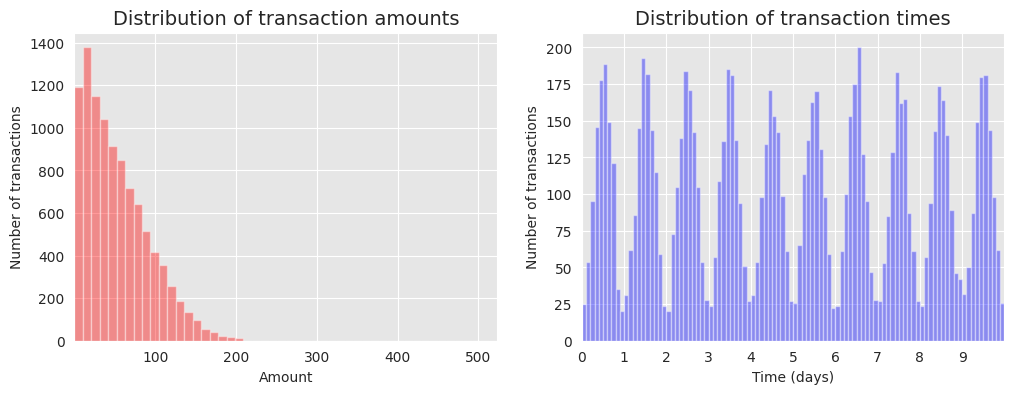

In [5]:
distribution_amount_times_fig

In [6]:
print('Total number of fraudolent transaction: ', transactions_df.TX_FRAUD.sum())
print('   Fraud scenario 1: ', transactions_df[transactions_df.TX_FRAUD_SCENARIO==1].shape[0])
print('   Fraud scenario 2: ', transactions_df[transactions_df.TX_FRAUD_SCENARIO==2].shape[0])
print('   Fraud scenario 3: ', transactions_df[transactions_df.TX_FRAUD_SCENARIO==3].shape[0])
print('Precentage of fraudolent transaction: ', round(transactions_df.TX_FRAUD.mean(),3))

Total number of fraudolent transaction:  14681
   Fraud scenario 1:  973
   Fraud scenario 2:  9077
   Fraud scenario 3:  4631
Precentage of fraudolent transaction:  0.008


# **2. Data pre-processing**

**Date and time transformations**

* `TX_DURING_WEEKEND` binary feature characterizing whether a transaction occurs during a weekday ($0$) or a weekend ($1$).
* `TX_DURING_NIGHT` binary feature characterizing whether a transaction occurs during the day or during the day between 6am and midnight ($0$) or during the night ($1$).  

In [7]:
def is_weekend(tx_datetime):
    # Transform date into weekday (0 is Monday, 6 is Sunday)
    weekday = tx_datetime.weekday()
    # Binary value: 0 if weekday, 1 if weekend
    is_weekend = weekday>=5
    return int(is_weekend)

def is_night(tx_datetime):
    # Get the hour of the transaction
    tx_hour = tx_datetime.hour
    # Binary value: 1 if hour less than 6, and 0 otherwise
    is_night = tx_hour<=6
    return int(is_night)

transactions_df['TX_DURING_WEEKEND'] = transactions_df.TX_DATETIME.apply(is_weekend)
transactions_df['TX_DURING_NIGHT'] = transactions_df.TX_DATETIME.apply(is_night)

**Customer ID transformations**

* Frequency features, i.e. the number of transactions occurring within a time window:
  * `CUSTOMER_ID_NB_TX_1DAY_WINDOW`	
  * `CUSTOMER_ID_NB_TX_7DAY_WINDOW`
  * `CUSTOMER_ID_NB_TX_30DAY_WINDOW`	
* Monetary value features, i.e. the average amount spent in these transactions:
  * `CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW`	
  * `CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW`	
  * `CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW`

Note that these time windows can later be optimized along with the models using a model selection procedure.  

In [8]:
def get_customer_spending_behaviour_features(customer_transactions, windows_size_in_days=[1,7,30]):
    # Let us first order transactions chronologically
    customer_transactions=customer_transactions.sort_values('TX_DATETIME')
    # The transaction date and time is set as the index, which will allow the use of the rolling function 
    customer_transactions.index=customer_transactions.TX_DATETIME

    # For each window size
    for window_size in windows_size_in_days:
        # Compute the sum of the transaction amounts and the number of transactions for the given window size
        SUM_AMOUNT_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').sum()
        NB_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').count()   
        # Compute the average transaction amount for the given window size
        # NB_TX_WINDOW is always >0 since current transaction is always included
        AVG_AMOUNT_TX_WINDOW=SUM_AMOUNT_TX_WINDOW/NB_TX_WINDOW    
        # Save feature values
        customer_transactions['CUSTOMER_ID_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        customer_transactions['CUSTOMER_ID_AVG_AMOUNT_'+str(window_size)+'DAY_WINDOW']=list(AVG_AMOUNT_TX_WINDOW)
    
    # Reindex according to transaction IDs
    customer_transactions.index=customer_transactions.TRANSACTION_ID
    return customer_transactions

transactions_df = transactions_df.groupby('CUSTOMER_ID').apply(lambda x: get_customer_spending_behaviour_features(x, windows_size_in_days=[1,7,30]))
transactions_df = transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

**Terminal ID transformations**

* Transaction number features, i.e. the amount of transactions that occurred on a terminal within a time window:
  * `TERMINAL_ID_NB_TX_1DAY_WINDOW`		
  * `TERMINAL_ID_NB_TX_7DAY_WINDOW`	
  * `TERMINAL_ID_NB_TX_30DAY_WINDOW`
* Risk score features, i.e. the proportion of fraudulent transactions that occurred on a terminal within a time window:
  * `TERMINAL_ID_RISK_1DAY_WINDOW`	
  * `TERMINAL_ID_RISK_7DAY_WINDOW`	
  * `TERMINAL_ID_RISK_30DAY_WINDOW`

Contrary to customer ID transformations, the time windows will not directly precede a given transaction. Instead, they will be shifted back by a delay period, accounting for the fact that, in practice, the fraudulent transactions are only discovered after a fraud investigation or a customer complaint. Hence, the fraudulent labels, which are needed to compute the risk score features, are only available after this delay period. To a first approximation, this delay period will be set to one week. 

In [9]:
def get_count_risk_rolling_window(terminal_transactions, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"):
    terminal_transactions=terminal_transactions.sort_values('TX_DATETIME')
    terminal_transactions.index=terminal_transactions.TX_DATETIME
    
    NB_FRAUD_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').sum()
    NB_TX_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').count()
    
    for window_size in windows_size_in_days:
        NB_FRAUD_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').sum()
        NB_TX_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').count()
    
        NB_FRAUD_WINDOW=NB_FRAUD_DELAY_WINDOW-NB_FRAUD_DELAY
        NB_TX_WINDOW=NB_TX_DELAY_WINDOW-NB_TX_DELAY
    
        RISK_WINDOW=NB_FRAUD_WINDOW/NB_TX_WINDOW
        
        terminal_transactions[feature+'_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        terminal_transactions[feature+'_RISK_'+str(window_size)+'DAY_WINDOW']=list(RISK_WINDOW)
        
    terminal_transactions.index=terminal_transactions.TRANSACTION_ID
    # Replace NA values with 0 (all undefined risk scores where NB_TX_WINDOW is 0) 
    terminal_transactions.fillna(0,inplace=True)
    
    return terminal_transactions

transactions_df = transactions_df.groupby('TERMINAL_ID').apply(lambda x: get_count_risk_rolling_window(x, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"))
transactions_df = transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

Save the transformed data

In [10]:
DIR_OUTPUT = "./simulated-data-transformed/data/"
if not os.path.exists(DIR_OUTPUT):
    os.makedirs(DIR_OUTPUT)

start_date = datetime.datetime.strptime("2018-04-01", "%Y-%m-%d")
for day in range(transactions_df.TX_TIME_DAYS.max()+1):    
    transactions_day = transactions_df[transactions_df.TX_TIME_DAYS==day].sort_values('TX_TIME_SECONDS')    
    date = start_date + datetime.timedelta(days=day)
    filename_output = date.strftime("%Y-%m-%d")+'.pkl'    
    # Protocol=4 required for Google Colab
    transactions_day.to_pickle(DIR_OUTPUT+filename_output, protocol=4)

Declare the variables of interest

In [ ]:
output_feature = "TX_FRAUD"

input_features = ['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

# **3. Machine Learning models in Scikit-Learn**

## **3.1 ML model selection**

### Utils

In [ ]:
def model_selection_wrapper(transactions_df, 
                            classifier, 
                            input_features, output_feature,
                            parameters, 
                            scoring, 
                            start_date_training_for_valid,
                            start_date_training_for_test,
                            n_folds=4,
                            delta_train=7, 
                            delta_delay=7, 
                            delta_assessment=7,
                            performance_metrics_list_grid=['roc_auc'],
                            performance_metrics_list=['AUC ROC'],
                            n_jobs=-1):

    # Get performances on the validation set using prequential validation
    performances_df_validation=prequential_grid_search(transactions_df, classifier, 
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_valid,
                            n_folds=n_folds,
                            expe_type='Validation',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            n_jobs=n_jobs)
    
    # Get performances on the test set using prequential validation
    performances_df_test=prequential_grid_search(transactions_df, classifier, 
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_test,
                            n_folds=n_folds,
                            expe_type='Test',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            n_jobs=n_jobs)
    
    # Bind the two resulting DataFrames
    performances_df_validation.drop(columns=['Parameters','Execution time'], inplace=True)
    performances_df=pd.concat([performances_df_test,performances_df_validation],axis=1)

    # And return as a single DataFrame
    return performances_df


In [ ]:
def get_summary_performances(performances_df, parameter_column_name="Parameters summary"):

    # Three performance metrics
    metrics = ['AUC ROC','Average precision','Card Precision@100']
    performances_results=pd.DataFrame(columns=metrics)
    
    # Reset indices in case a subset of a performane DataFrame is provided as input
    performances_df.reset_index(drop=True,inplace=True)

    # Lists of parameters/performances that will be retrieved for the best estimated parameters
    best_estimated_parameters = []
    validation_performance = []
    test_performance = []
    
    # For each performance metric, get the validation and test performance for the best estimated parameter
    for metric in metrics:
    
        # Find the index which provides the best validation performance
        index_best_validation_performance = performances_df.index[np.argmax(performances_df[metric+' Validation'].values)]
    
        # Retrieve the corresponding parameters
        best_estimated_parameters.append(performances_df[parameter_column_name].iloc[index_best_validation_performance])
        
        # Add validation performance to the validation_performance list (mean+/-std)
        validation_performance.append(
                str(round(performances_df[metric+' Validation'].iloc[index_best_validation_performance],3))+
                '+/-'+
                str(round(performances_df[metric+' Validation'+' Std'].iloc[index_best_validation_performance],2))
        )
        
        # Add test performance to the test_performance list (mean+/-std)
        test_performance.append(
                str(round(performances_df[metric+' Test'].iloc[index_best_validation_performance],3))+
                '+/-'+
                str(round(performances_df[metric+' Test'+' Std'].iloc[index_best_validation_performance],2))
        )
    
    # Add results to the performances_results DataFrame
    performances_results.loc["Best estimated parameters"]=best_estimated_parameters
    performances_results.loc["Validation performance"]=validation_performance
    performances_results.loc["Test performance"]=test_performance

    # Lists of parameters/performances that will be retrieved for the optimal parameters
    optimal_test_performance = []
    optimal_parameters = []

    # For each performance metric, get the performance for the optimal parameter
    for metric in ['AUC ROC Test','Average precision Test','Card Precision@100 Test']:
    
        # Find the index which provides the optimal performance
        index_optimal_test_performance = performances_df.index[np.argmax(performances_df[metric].values)]
    
        # Retrieve the corresponding parameters
        optimal_parameters.append(performances_df[parameter_column_name].iloc[index_optimal_test_performance])
    
        # Add test performance to the test_performance list (mean+/-std)
        optimal_test_performance.append(
                str(round(performances_df[metric].iloc[index_optimal_test_performance],3))+
                '+/-'+
                str(round(performances_df[metric+' Std'].iloc[index_optimal_test_performance],2))
        )

    # Add results to the performances_results DataFrame
    performances_results.loc["Optimal parameters"]=optimal_parameters
    performances_results.loc["Optimal test performance"]=optimal_test_performance
    
    return performances_results


### Train, validation and test sets

In [ ]:
DIR_INPUT = 'simulated-data-transformed/data/' 
BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"
transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)

In [ ]:
n_folds = 4   # validation folds

start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = delta_valid = delta_assessment = 7

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)

# Keep only the useful dataframe columns
compact_transactions_df = transactions_df[['CUSTOMER_ID', 'TX_FRAUD', 'TX_TIME_DAYS']]
card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=compact_transactions_df)

performance_metrics_list_grid = ['roc_auc', 'average_precision', 'card_precision@100']
performance_metrics_list = ['AUC ROC', 'Average precision', 'Card Precision@100']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100,
           }

### Analysis

In [ ]:
classifiers_list = ['K-NN', 'Logistic Regression', 'Decision Tree', 
                    'Random Forest', 'XGBoost']

model_dict = {'K-NN': sklearn.neighbors.KNeighborsClassifier(),
              'Logistic Regression': sklearn.linear_model.LogisticRegression(),
              'Decision Tree': sklearn.tree.DecisionTreeClassifier(), 
              'Random Forest': sklearn.ensemble.RandomForestClassifier(),
              'XGBoost': xgboost.XGBClassifier(),
}

param_dict = {'K-NN': {'clf__n_neighbors': [3, 5, 10]},
              'Logistic Regression': {'clf__C': [0.1, 1, 10, 100], 'clf__random_state': [0]},
              'Decision Tree': {'clf__max_depth': [3, 5, 50], 'clf__random_state': [0]}, 
              'Random Forest': {'clf__max_depth': [10, 20], 'clf__n_estimators': [50, 100], 
                                'clf__random_state': [0], 'clf__n_jobs': [1]},
              'XGBoost': {'clf__max_depth': [3, 6], 'clf__n_estimators': [25, 50, 100], 'clf__learning_rate': [0.1, 0.3],
                          'clf__random_state': [0], 'clf__n_jobs': [1], 'clf__verbosity': [0]},
}

performances_df_list = []
execution_time_list = []
for classifier_name in classifiers_list:
  # Define classifier
  classifier = model_dict[classifier_name]
  # Set of parameters for which to assess model performances
  parameters = param_dict[classifier_name]

  start_time = time.time()

  # Fit models and assess performances for all parameters
  performances_df = model_selection_wrapper(transactions_df, classifier, 
                                            input_features, output_feature,
                                            parameters, scoring, 
                                            start_date_training_for_valid,
                                            start_date_training_for_test,
                                            n_folds=n_folds,
                                            delta_train=delta_train, 
                                            delta_delay=delta_delay, 
                                            delta_assessment=delta_assessment,
                                            performance_metrics_list_grid=performance_metrics_list_grid,
                                            performance_metrics_list=performance_metrics_list,
                                            n_jobs=1)

  execution_time_list.append(time.time() - start_time)

  # Select parameter of interest (max_depth)
  param_performance_dict = dict(performances_df['Parameters'])

  param_summary = []
  for i in range(performances_df.shape[0]):
    scores = []
    param_list = list(param_dict[classifier_name].keys())
    if 'clf__random_state' in param_list: param_list.remove('clf__random_state')
    if 'clf__n_jobs' in param_list: param_list.remove('clf__n_jobs')
    if 'clf__verbosity' in param_list: param_list.remove('clf__verbosity')
    for param in param_list:
      scores.append(str(performances_df['Parameters'][i][param]))
    param_summary.append('/'.join(scores))

  performances_df['Parameters summary'] = param_summary
  performances_df_list.append(performances_df)

The first row of the performance table will provide the parameters that maximize the performances on the validation set (best estimated parameters). The second and third rows provide the corresponding performances on the validation and test sets, respectively. The fourth row provides the actual optimal parameters on the test set (the parameters that maximize the performances on the test set). The fifth row provides the corresponding performances on the test set.

**K-NN**

K-NN
                                AUC ROC Average precision Card Precision@100
Best estimated parameters            10                10                 10
Validation performance     0.808+/-0.01      0.534+/-0.02       0.251+/-0.01
Test performance           0.807+/-0.01       0.54+/-0.02       0.259+/-0.01
Optimal parameters                   10                10                 10
Optimal test performance   0.807+/-0.01       0.54+/-0.02       0.259+/-0.01





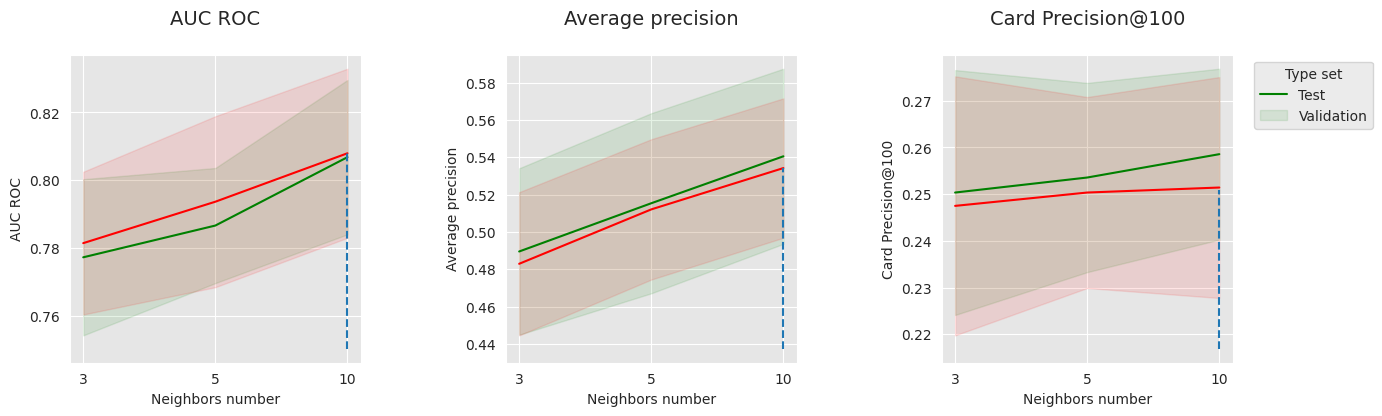

In [ ]:
print('K-NN')
summary_performances_df = get_summary_performances(performances_df_list[0], parameter_column_name="Parameters summary")
print(summary_performances_df)
print('\n\n')
get_performances_plots(performances_df_list[0], 
                      performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                      expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                      parameter_name="Neighbors number",
                      summary_performances=summary_performances_df)

**Logistic Regression**

Logistic Regression
                                AUC ROC Average precision Card Precision@100
Best estimated parameters           100               100                0.1
Validation performance     0.867+/-0.01      0.613+/-0.02       0.279+/-0.02
Test performance           0.868+/-0.02      0.623+/-0.02       0.297+/-0.01
Optimal parameters                  100               100                 10
Optimal test performance   0.868+/-0.02      0.623+/-0.02       0.298+/-0.01





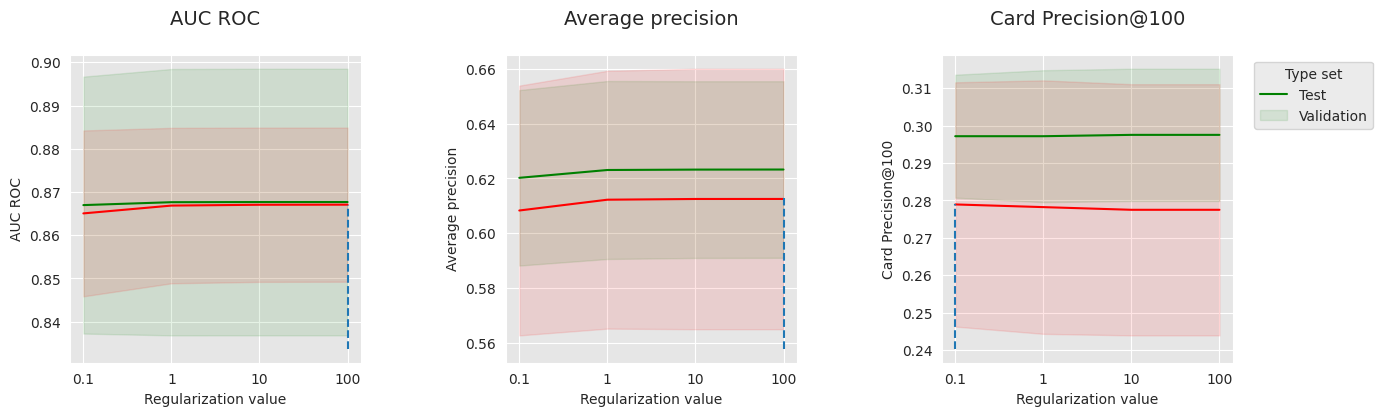

In [ ]:
print('Logistic Regression')
summary_performances_df = get_summary_performances(performances_df_list[1], parameter_column_name="Parameters summary")
print(summary_performances_df)
print('\n\n')
get_performances_plots(performances_df_list[1], 
                      performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                      expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                      parameter_name="Regularization value",
                      summary_performances=summary_performances_df)

**Decision Tree**

Decision Tree
                                AUC ROC Average precision Card Precision@100
Best estimated parameters            50                 3                  5
Validation performance     0.823+/-0.01      0.573+/-0.03       0.268+/-0.01
Test performance           0.797+/-0.01      0.579+/-0.01        0.284+/-0.0
Optimal parameters                    5                 5                  5
Optimal test performance    0.81+/-0.01        0.6+/-0.02        0.284+/-0.0





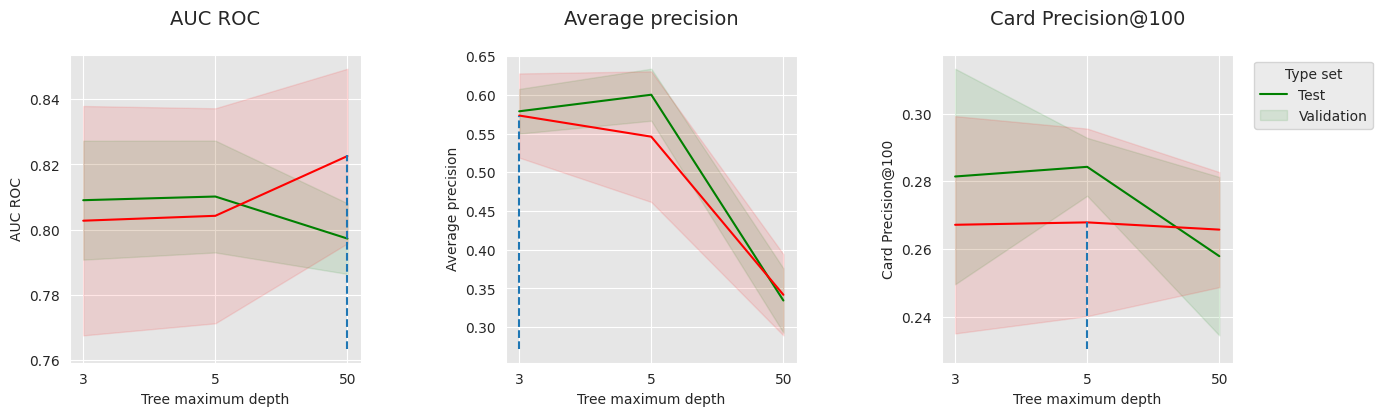

In [ ]:
print('Decision Tree')
summary_performances_df = get_summary_performances(performances_df_list[2], parameter_column_name="Parameters summary")
print(summary_performances_df)
print('\n\n')
get_performances_plots(performances_df_list[2], 
                      performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                      expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                      summary_performances=summary_performances_df)

**Random Forest**

Random Forest
                                AUC ROC Average precision Card Precision@100
Best estimated parameters        20/100            20/100             20/100
Validation performance      0.88+/-0.01      0.694+/-0.02       0.289+/-0.02
Test performance            0.87+/-0.02      0.678+/-0.01       0.299+/-0.01
Optimal parameters               10/100            20/100             10/100
Optimal test performance   0.875+/-0.01      0.678+/-0.01       0.303+/-0.01





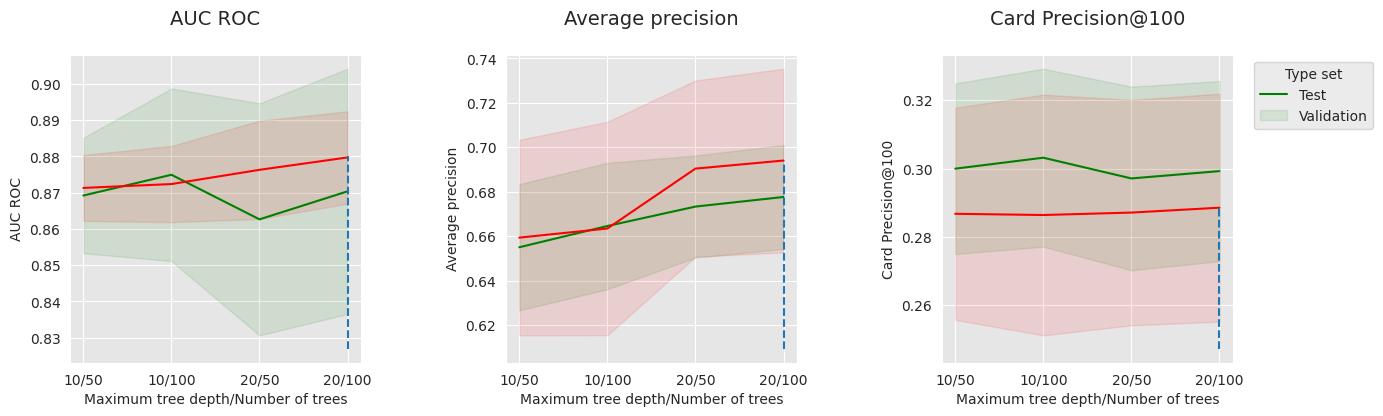

In [ ]:
print('Random Forest')
summary_performances_df = get_summary_performances(performances_df_list[3], parameter_column_name="Parameters summary")
print(summary_performances_df)
print('\n\n')
get_performances_plots(performances_df_list[3], 
                      performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                      expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                      parameter_name="Maximum tree depth/Number of trees",
                      summary_performances=summary_performances_df)

**XGBoost**

XGBoost
                                AUC ROC Average precision Card Precision@100
Best estimated parameters     3/100/0.3          3/50/0.3           3/25/0.3
Validation performance     0.887+/-0.01      0.708+/-0.02       0.289+/-0.02
Test performance           0.869+/-0.01      0.687+/-0.01       0.303+/-0.01
Optimal parameters             3/50/0.3          3/50/0.3           3/25/0.3
Optimal test performance   0.872+/-0.01      0.687+/-0.01       0.303+/-0.01





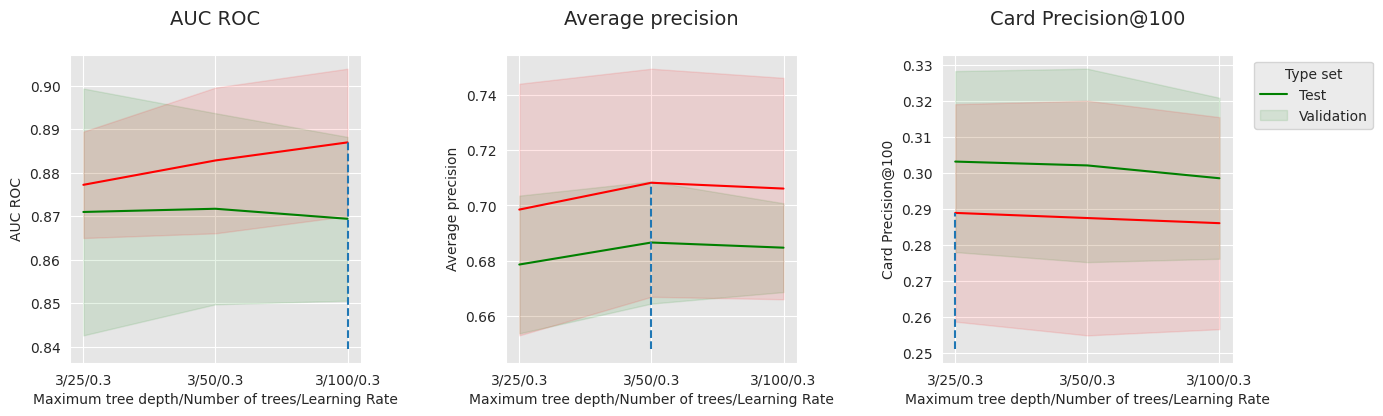

In [ ]:
print('XGBoost')
summary_performances_df = get_summary_performances(performances_df_list[4].iloc[6:9,:], parameter_column_name="Parameters summary")
print(summary_performances_df)
print('\n\n')
get_performances_plots(performances_df_list[4].iloc[6:9,:], 
                      performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                      expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                      parameter_name="Maximum tree depth/Number of trees/Learning Rate",
                      summary_performances=summary_performances_df)

**Execution time**

In [ ]:
%%capture
model_selection_execution_times, ax = plt.subplots(1, 1, figsize=(5,4))
    
# width of the bars
barWidth = 0.3
# The x position of bars
r1 = np.arange(len(classifiers_list))
    
# Create execution times bars
ax.bar(r1, execution_time_list, 
        width = barWidth, color = 'blue', edgecolor = 'black', 
        capsize=7)

ax.set_xticks(r1+barWidth/2)
ax.set_xticklabels(classifiers_list, rotation = 45, ha="right", fontsize=12)
ax.set_title('Model selection execution times', fontsize=18)
ax.set_xlabel("Model class", fontsize=16)
ax.set_ylabel("Execution times (s)", fontsize=15)

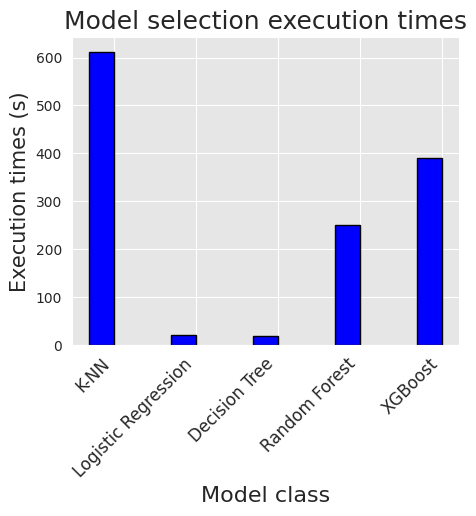

In [ ]:
model_selection_execution_times

## **3.2 ML model evaluation**

### Utils

**Training and testing**

In [ ]:
def get_train_test_set(transactions_df,
                       start_date_training,
                       delta_train=7, delta_delay=7, delta_test=7):
    
    # Training set
    train_df = transactions_df[(transactions_df.TX_DATETIME >= start_date_training) &
                               (transactions_df.TX_DATETIME < start_date_training + datetime.timedelta(days = delta_train))]
    
    # Relative starting day of the training set
    start_tx_time_days_training = train_df.TX_TIME_DAYS.min()
    
    # Customers known to be fraudolent from the test set
    known_defrauded_customers = set(train_df[train_df.TX_FRAUD==1].CUSTOMER_ID)
    # Note: Cards known to be compromised after the delay period are removed from the test set
    # That is, for each test day, all frauds known at (test_day - delay_period) are removed
    
    # Test set
    test_df = []
    
    # For each day of the test set
    for day in range(delta_test):
        test_df_day = transactions_df[transactions_df.TX_TIME_DAYS == start_tx_time_days_training + delta_train + delta_delay + day]
        
        # Compromised cards from that test day, minus the delay period, are added to the pool of known defrauded customers
        test_df_day_delay_period = transactions_df[transactions_df.TX_TIME_DAYS == start_tx_time_days_training + delta_train + day-1]
        
        new_defrauded_customers = set(test_df_day_delay_period[test_df_day_delay_period.TX_FRAUD == 1].CUSTOMER_ID)
        known_defrauded_customers = known_defrauded_customers.union(new_defrauded_customers)
        
        test_df_day = test_df_day[~test_df_day.CUSTOMER_ID.isin(known_defrauded_customers)]
        test_df.append(test_df_day)
        
    test_df = pd.concat(test_df)
    
    # Sort datasets by ascending order of transaction ID
    train_df = train_df.sort_values('TRANSACTION_ID')
    test_df = test_df.sort_values('TRANSACTION_ID')
    
    return (train_df, test_df)

In [ ]:
def fit_model_and_get_predictions(classifier, train_df, test_df, 
                                  input_features, output_feature="TX_FRAUD", scale=True):

    # By default, scales the input data --> standardization w.r.t. mean and variance
    if scale:
        scaler = sklearn.preprocessing.StandardScaler()  
        scaler.fit(train_df[input_features])
        train_df[input_features] = scaler.transform(train_df[input_features])
        test_df[input_features] = scaler.transform(test_df[input_features]) 
    
    # Model fitting
    start_time = time.time()
    classifier.fit(train_df[input_features], train_df[output_feature])
    training_execution_time = time.time() - start_time

    # Model predictions
    start_time = time.time()
    predictions_test = classifier.predict_proba(test_df[input_features])[:,1]
    prediction_execution_time = time.time() - start_time
    predictions_train = classifier.predict_proba(train_df[input_features])[:,1]

    model_and_predictions_dictionary = {'classifier': classifier,
                                        'predictions_test': predictions_test,
                                        'predictions_train': predictions_train,
                                        'training_execution_time': training_execution_time,
                                        'prediction_execution_time': prediction_execution_time
                                       }
    
    return model_and_predictions_dictionary

In [ ]:
# Getting classes from a vector of fraud probabilities and a threshold
def get_class_from_fraud_probability(fraud_probabilities, threshold=0.5):   
    predicted_classes = [0 if fraud_probability < threshold else 1 
                         for fraud_probability in fraud_probabilities]
    return predicted_classes

In [ ]:
# Mean Mis-classification Error
def compute_MME(true_labels, predicted_classes):
    N = len(true_labels)    
    MME = np.sum(np.array(true_labels) != np.array(predicted_classes)) / N    
    return MME

**Threshold-based metrics**

In [ ]:
def threshold_based_metrics(fraud_probabilities, true_label, threshold=0.5, model_name='model'):
    results = []

    predicted_classes = get_class_from_fraud_probability(fraud_probabilities, threshold=threshold)
    TN, FP, FN, TP = metrics.confusion_matrix(true_label, list(predicted_classes)).ravel()
 
    MME = (FP+FN)/(TN+FP+FN+TP)   # Mean mis-classification error
    TPR = TP/(TP+FN)              # True positive rate
    TNR = TN/(TN+FP)              # True negative rate 
    FPR = FP/(TN+FP)              # False positive rate
    FNR = FN/(TP+FN)              # False negative rate
    BER = 1/2*(FPR+FNR)           # Balanced error rate
    Gmean = np.sqrt(TPR*TNR)      # Geometric mean

    precision = 0                 
    FDR = 0                                     
    if TP+FP>0:
        precision = TP/(TP+FP)    # Precision
        FDR = FP/(TP+FP)          # False discovery rate
    
    NPV = 0                      
    FOR = 0                       
    if TN+FN>0:
        NPV = TN/(TN+FN)          # Negative predictive value
        FOR = FN/(TN+FN)          # False omission rate

    F1_score=0 
    if precision+TPR>0:
        F1_score = 2*(precision*TPR)/(precision+TPR)    # F1-score

    results_df = pd.DataFrame(columns=['Threshold' ,'MME', 'TPR', 'TNR', 'FPR', 'FNR', 'BER', 'G-mean', 'Precision', 'NPV', 'FDR', 'FOR', 'F1 Score'])
    results_df.loc[0] = [threshold, MME, TPR, TNR, FPR, FNR, BER, Gmean, precision, NPV, FDR, FOR, F1_score]
    results_df.index = [model_name]
    return results_df

**Threshold-free metrics**

In [ ]:
def get_template_roc_curve(ax, title,fs,random=True):
    
    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    
    ax.set_xlabel('False Positive Rate', fontsize=fs)
    ax.set_ylabel('True Positive Rate', fontsize=fs)
    
    if random:
        ax.plot([0, 1], [0, 1],'r--',label="AUC ROC Random = 0.5")

In [ ]:
def get_template_pr_curve(ax, title,fs, baseline=0.5):
    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    
    ax.set_xlabel('Recall (True Positive Rate)', fontsize=fs)
    ax.set_ylabel('Precision', fontsize=fs)
    
    ax.plot([0, 1], [baseline, baseline],'r--',label='AP Random = {0:0.3f}'.format(baseline))

**Precision top-k metrics**

In [ ]:
def card_precision_top_k_day(df_day, top_k):
    '''
    This metric takes into account the fact that investigators can 
    only check a maximum of k potentially fraudulent cards per day. 
    For a day d in the test set, we detect the most fraudulent transactions
    and select the k cards whose transactions have the highest fraud probabilities. 
    The precision is computed by taking the proportion of the selected k actual compromised cards 
    out of predicted compromised cards for day d, and then average the results.
    '''
    
    # This takes the max of the predictions AND the max of label TX_FRAUD for each CUSTOMER_ID, 
    # and sorts by decreasing order of fraudulent prediction
    df_day = df_day.groupby('CUSTOMER_ID').max().sort_values(by="predictions", ascending=False).reset_index(drop=False)
            
    # Get the top k most suspicious cards
    df_day_top_k = df_day.head(top_k)
    list_detected_compromised_cards = list(df_day_top_k[df_day_top_k.TX_FRAUD==1].CUSTOMER_ID)
    
    # Compute precision top k
    card_precision_top_k = len(list_detected_compromised_cards) / top_k
    
    return list_detected_compromised_cards, card_precision_top_k

In [ ]:
def card_precision_top_k(predictions_df, top_k, remove_detected_compromised_cards=True):
    '''
    This metric is a proxy of the card_precision_top_k_day
    because the function loops over all days of the dataset 
    and averages the precision top-k values.
    '''

    # Sort days by increasing order
    list_days = list(predictions_df['TX_TIME_DAYS'].unique())
    list_days.sort()
  
    list_detected_compromised_cards = []
    card_precision_top_k_per_day_list = []
    nb_compromised_cards_per_day = []
    
    # For each day, compute precision top k
    for day in list_days:
        df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
        df_day = df_day[['predictions', 'CUSTOMER_ID', 'TX_FRAUD']]
        
        # Remove detected compromised cards from the set of daily transactions
        df_day = df_day[df_day.CUSTOMER_ID.isin(list_detected_compromised_cards)==False]        
        nb_compromised_cards_per_day.append(len(df_day[df_day.TX_FRAUD==1].CUSTOMER_ID.unique()))       
        detected_compromised_cards, card_precision_top_k = card_precision_top_k_day(df_day,top_k)        
        card_precision_top_k_per_day_list.append(card_precision_top_k)
        
        # Update the list of detected compromised cards
        if remove_detected_compromised_cards:
            list_detected_compromised_cards.extend(detected_compromised_cards)
        
    # Compute the mean
    mean_card_precision_top_k = np.array(card_precision_top_k_per_day_list).mean()
    
    return nb_compromised_cards_per_day, card_precision_top_k_per_day_list, mean_card_precision_top_k

### Train and test datasets

In [ ]:
# Initialization: Load shared functions and simulated data 
DIR_INPUT = './simulated-data-transformed/data/' 
BEGIN_DATE = "2018-07-25"
END_DATE = "2018-08-14"
transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)

start_date_training = datetime.datetime.strptime(BEGIN_DATE, "%Y-%m-%d")
(train_df, test_df) = get_train_test_set(transactions_df, start_date_training)

In [ ]:
print('Training set shape: ', train_df.shape)
print('Training set proportion of frauds: ', round(train_df[train_df.TX_FRAUD==1].shape[0] / train_df.shape[0], 3))
print('Test set shape: ', test_df.shape)
print('Test set proportion of frauds: ', round(test_df[test_df.TX_FRAUD==1].shape[0] / test_df.shape[0], 3))

Training set shape:  (67240, 23)
Training set proportion of frauds:  0.009
Test set shape:  (58264, 23)
Test set proportion of frauds:  0.007


### Model definition

In [ ]:
!pip install shap

In [ ]:
import shap

#### K-Nearest Neighbors

In [ ]:
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10)
knn_dictionary = fit_model_and_get_predictions(knn, train_df, test_df, 
                                               input_features, output_feature,
                                               scale=False)

#### Logistic Regression

In [ ]:
logistic_reg = sklearn.linear_model.LogisticRegression(C=10, random_state=0)
logistic_reg_dictionary = fit_model_and_get_predictions(logistic_reg, train_df, test_df, 
                                                        input_features, output_feature,
                                                        scale=False)

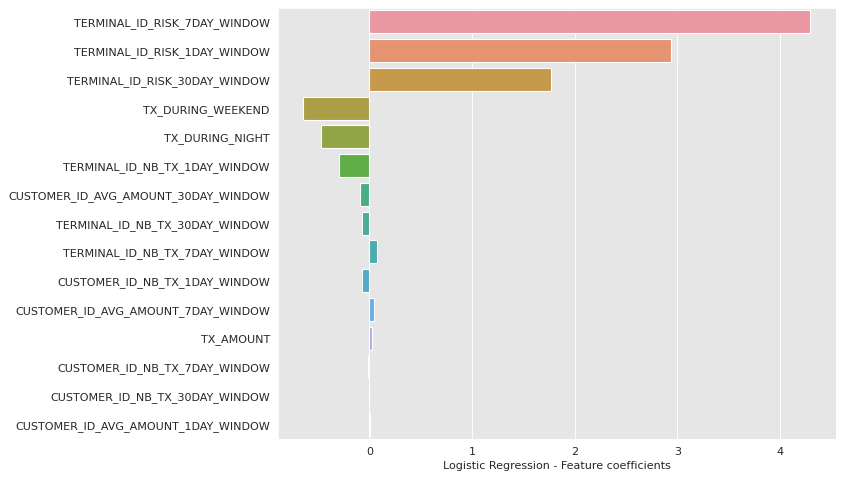

In [ ]:
logistic_reg_coeff = pd.DataFrame(index=input_features, 
                                  data={'Logistic Regression - Feature coefficients': logistic_reg.coef_[0]})
logistic_reg_coeff = logistic_reg_coeff.sort_values(by='Logistic Regression - Feature coefficients', key=abs, ascending=False)

plt.figure(figsize=(9, 7), dpi=80)
sns.barplot(x = 'Logistic Regression - Feature coefficients',
            y = logistic_reg_coeff.index, 
            data = logistic_reg_coeff)
plt.show()

According to the model, the features that influence more the fraud event are:
* a high terminal risk within the 1, 7 or 30 days window;
* a transaction happening during the weekdays and during the daytime.

#### Decision Trees

**Depth = 2**

In [ ]:
decision_tree_depth2 = sklearn.tree.DecisionTreeClassifier(max_depth=2, random_state=0)
decision_tree_depth2_dictionary = fit_model_and_get_predictions(decision_tree_depth2, train_df, test_df, 
                                                         input_features, output_feature,
                                                         scale=False)

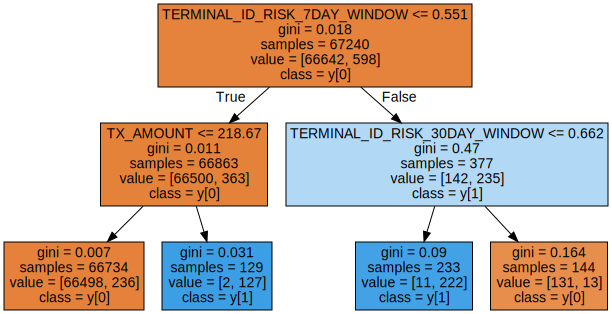

In [ ]:
display(graphviz.Source(sklearn.tree.export_graphviz(decision_tree_depth2, feature_names=input_features, class_names=True, filled=True)))

The color indicates whether a node or leaf of the tree contains a majority of genuine (orange) or fraudulent (blue) transactions.

According to the model, the features that influence more the fraud event are:
* a high transaction amount;
* a high terminal risk within the 7 days window;
* a low terminal risk within the 30 days window.



**Unlimited depht**

In [ ]:
decision_tree = sklearn.tree.DecisionTreeClassifier(random_state=0)
decision_tree_dictionary = fit_model_and_get_predictions(decision_tree, train_df, test_df, 
                                                         input_features, output_feature,
                                                         scale=False)

#### Random Forest

In [ ]:
random_forest = sklearn.ensemble.RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=-1, random_state=0)
random_forest_dictionary = fit_model_and_get_predictions(random_forest, train_df, test_df, 
                                                         input_features, output_feature,
                                                         scale=False)

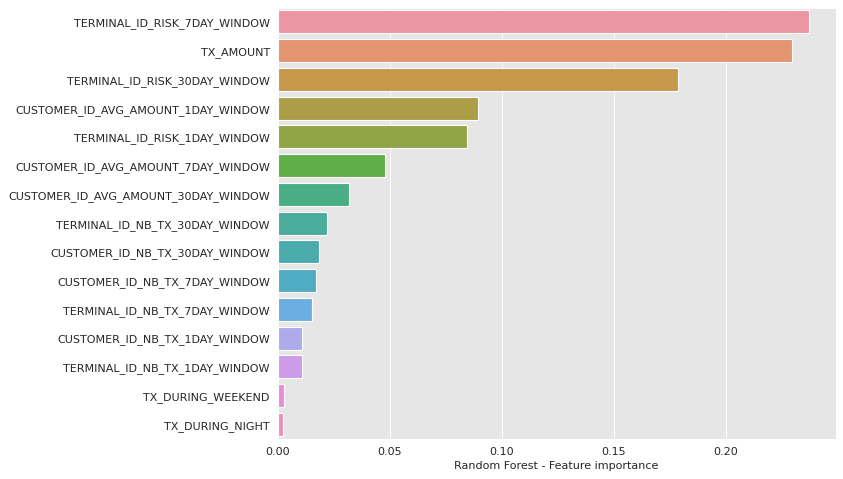

In [ ]:
random_forest_coeff = pd.DataFrame(index=input_features, 
                                   data={'Random Forest - Feature importance': random_forest.feature_importances_})
random_forest_coeff = random_forest_coeff.sort_values(by='Random Forest - Feature importance', key=abs, ascending=False)

plt.figure(figsize=(9, 7), dpi=80)
sns.barplot(x = 'Random Forest - Feature importance',
            y = random_forest_coeff.index, 
            data = random_forest_coeff)
plt.show()

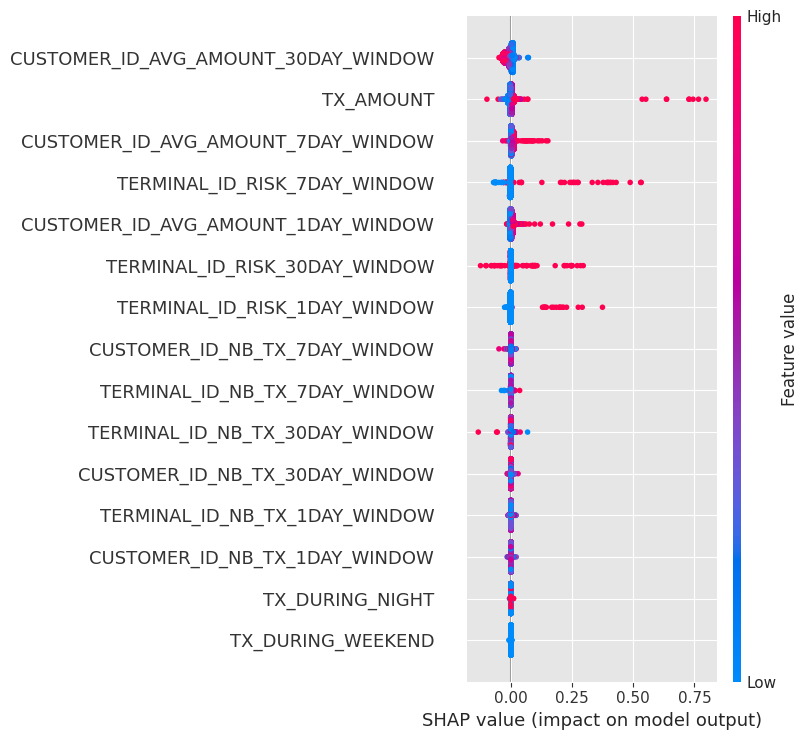

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(random_forest)
# choose a subset of the train set due to computational time limits
shap_values = explainer.shap_values(train_df[input_features].iloc[:5000,:])
shap.summary_plot(shap_values[1], train_df[input_features].iloc[:5000,:])

The plot is divided into two panels: classified as 'genuine' on the left, classified as 'fraudulent' on the right. 

The colors give us an idea about the magnitude of the responses to each item: for almost all the items, a high value (red) corresponds to a high probability to be classified as 'fraudulent', while a low value (blue) corresponds to a high probability to be classified as 'genuine'.

This trend is inverted for the feature `CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW`, meaning the lower the average amount of money spent by the costumer in the 30 days window, the higher the probability to commit fraud.

#### XGBoost

In [ ]:
xgboost = xgboost.XGBClassifier(max_depth=3, n_estimators=25, learning_rate=0.3, n_jobs=-1, random_state=0)
xgboost_dictionary = fit_model_and_get_predictions(xgboost, train_df, test_df, 
                                                   input_features, output_feature,
                                                   scale=False)

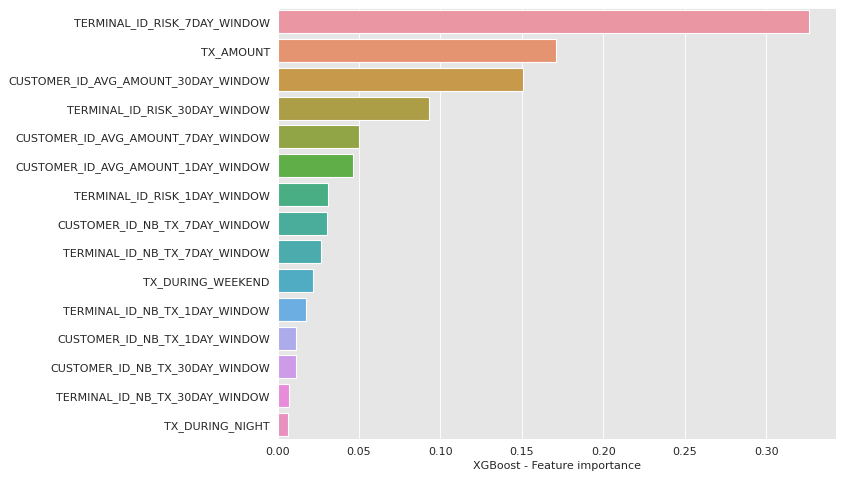

In [ ]:
xgboost_coeff = pd.DataFrame(index=input_features, 
                             data={'XGBoost - Feature importance': xgboost.feature_importances_})
xgboost_coeff = xgboost_coeff.sort_values(by='XGBoost - Feature importance', key=abs, ascending=False)

plt.figure(figsize=(9, 7), dpi=80)
sns.barplot(x = 'XGBoost - Feature importance',
            y = xgboost_coeff.index, 
            data = xgboost_coeff)
plt.show()

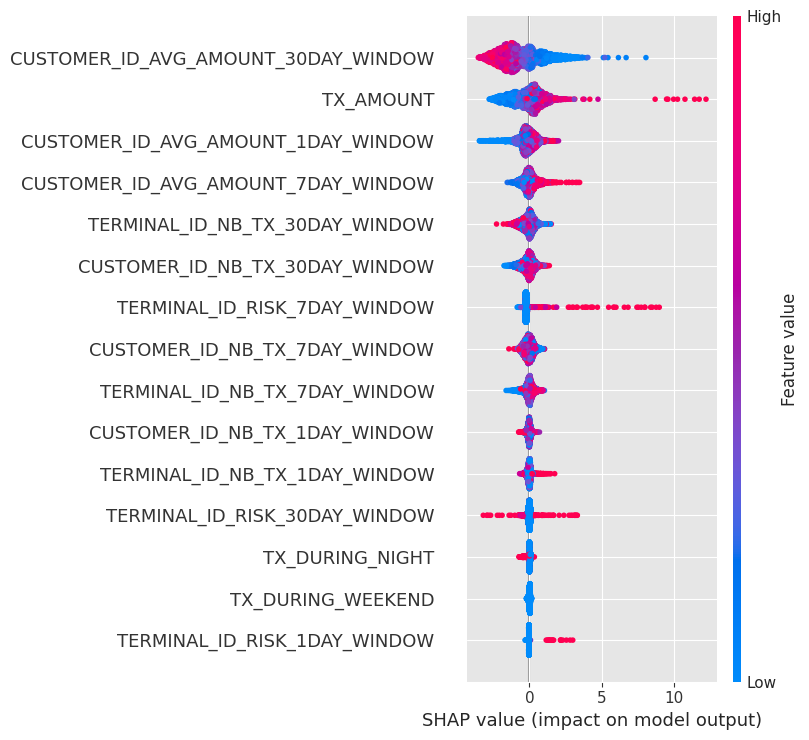

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(xgboost)
# choose a subset of the train set due to computational time limits
shap_values = explainer.shap_values(train_df[input_features].iloc[:5000,:])
shap.summary_plot(shap_values, train_df[input_features].iloc[:5000,:])

According to the model, the features that influence more the fraud event are:
* low value of the average amount of money spent by the costumer in the 30 days window, but high values for the corresponding features in the 1 and 7 days windows;
* high transiction amount;
* high number of customer's transactions in the 30 days window, but low number for the corresponding feature in the 7 days windows;
* low number of transactions in a terminal in the 30 days window, but high terminal risk in the 7 days windows.

### Model comparison

In [ ]:
# Random classifier
random_dictionary = {'predictions_train': np.repeat(0.5, len(train_df)),
                     'predictions_test': np.repeat(0.5, len(test_df))}

In [ ]:
classifiers_list = ['K-NN', 'Logistic Regression', 
                    'Decision Tree - depth=2', 'Decision Tree - unlimited depth', 
                    'Random Forest', 'XGBoost']
dictionaries_list = [knn_dictionary, logistic_reg_dictionary, 
                     decision_tree_depth2_dictionary, decision_tree_dictionary, 
                     random_forest_dictionary, xgboost_dictionary]

#### Execution time

In [ ]:
time_performances = pd.DataFrame() 
model_timing = pd.DataFrame() 
for classifier, dictionary in zip(classifiers_list, dictionaries_list):
    model_timing['Training execution time'] = [dictionary['training_execution_time']]
    model_timing['Prediction execution time'] = [dictionary['prediction_execution_time']]
    model_timing.index = [classifier]
    time_performances = time_performances.append(model_timing)

time_performances

Training execution time  \
K-NN                                            0.350635   
Logistic Regression                             2.655469   
Decision Tree - depth=2                         0.133732   
Decision Tree - unlimited depth                 1.226263   
Random Forest                                   6.397850   
XGBoost                                         2.781479   

                                 Prediction execution time  
K-NN                                              8.454066  
Logistic Regression                               0.019505  
Decision Tree - depth=2                           0.009002  
Decision Tree - unlimited depth                   0.014265  
Random Forest                                     0.315853  
XGBoost                                           0.034277

As expected, the execution times for training ensembles of models, namely Random Forest and XGBoost, is significantly higher than single models.

#### Confusion matrix

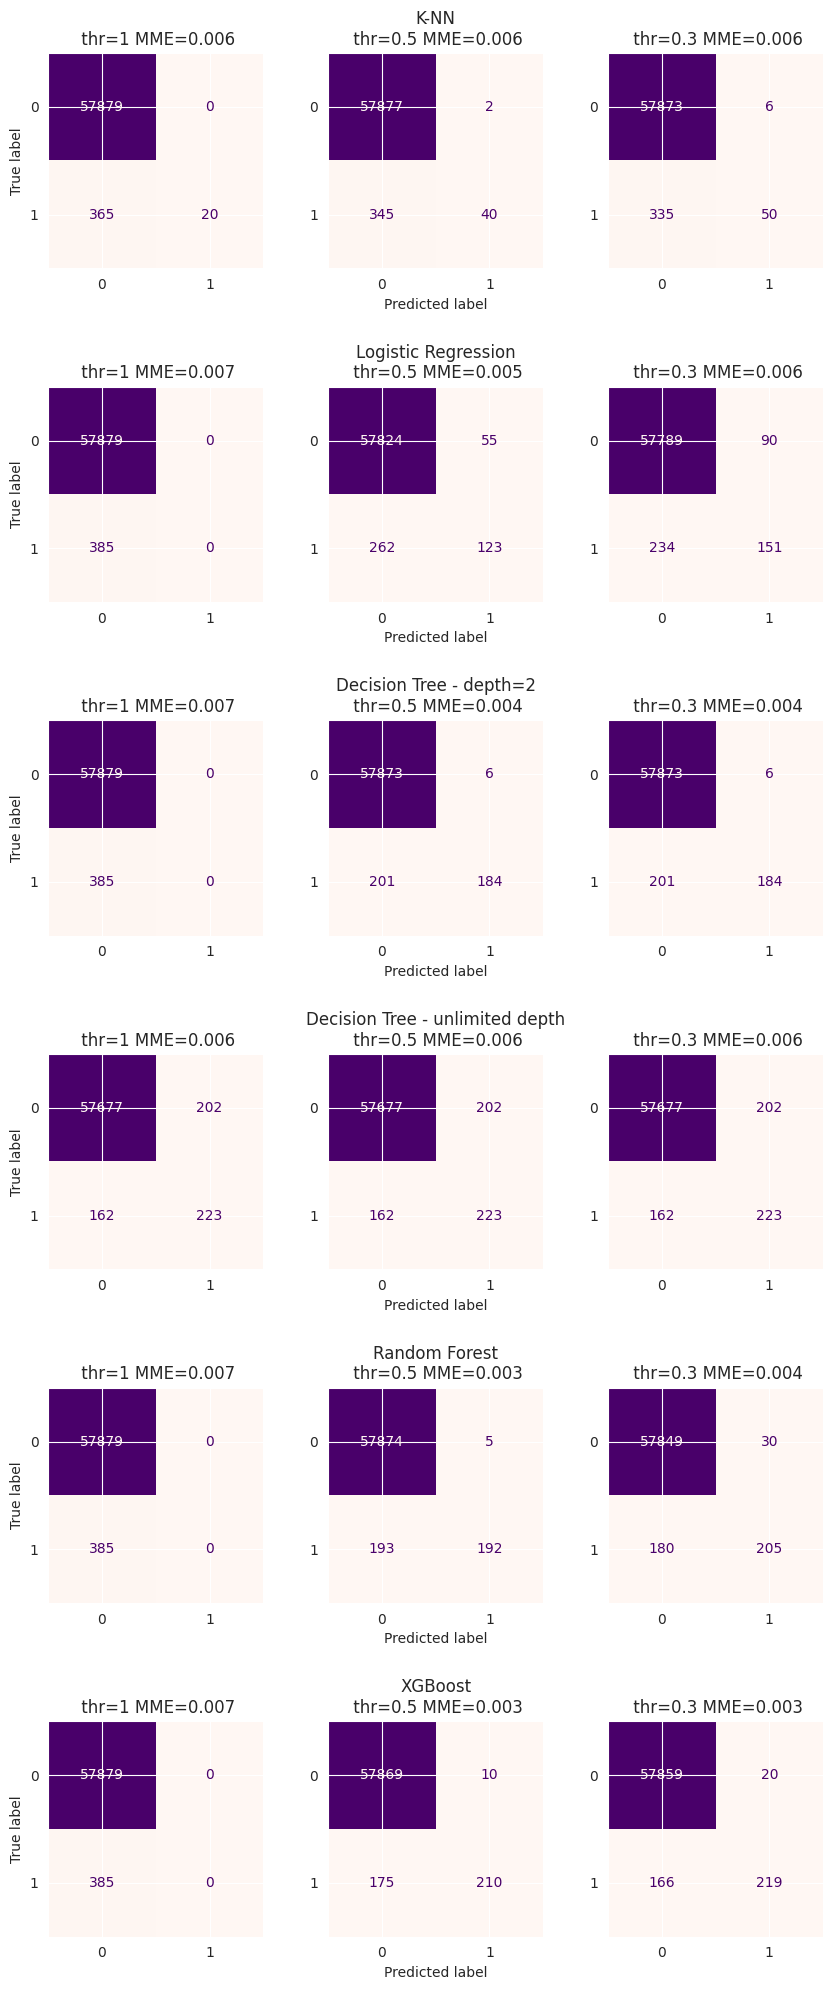

In [ ]:
confusion_matrix_plots, axes = plt.subplots(6, 3, figsize=(10, 25))
thresholds = [1, 0.5, 0.3]
model_count = 0
for classifier, dictionary in zip(classifiers_list, dictionaries_list):
  for idx in range(len(thresholds)):
      predicted_classes = get_class_from_fraud_probability(dictionary['predictions_test'], 
                                                           threshold=thresholds[idx])
      MME = compute_MME(test_df['TX_FRAUD'], predicted_classes)
      cf_matrix = confusion_matrix(test_df['TX_FRAUD'], predicted_classes)
      disp = ConfusionMatrixDisplay(cf_matrix, display_labels=[0, 1])
      disp.plot(ax=axes[model_count, idx], cmap=plt.cm.RdPu)
      if idx != 1:
        disp.ax_.set_title('\n thr=' + str(thresholds[idx]) +
                          ' MME=' + str(np.round(MME, 3)))
      else:
        disp.ax_.set_title(classifier + '\n thr=' + str(thresholds[idx]) +
                                  ' MME=' + str(np.round(MME, 3)))
      disp.im_.colorbar.remove()
      if idx != 1:
        disp.ax_.set_xlabel('')
      if idx != 0:
        disp.ax_.set_ylabel('')

  #confusion_matrix_plots.colorbar(disp.im_, ax=axes[model_count, idx])
  model_count += 1
  
plt.subplots_adjust(wspace=0.3, hspace=0.3)

#### Threshold-based metrics

In [ ]:
test_metrics = pd.DataFrame() 
model_scores = pd.DataFrame() 
true_labels = test_df['TX_FRAUD']
for classifier, dictionary in zip(classifiers_list, dictionaries_list):
    fraud_probs = dictionary['predictions_test']
    model_scores = threshold_based_metrics(fraud_probs, true_labels, threshold=0.3, model_name=classifier)  # a low threshold tends to lower the false negatives
    test_metrics = test_metrics.append(model_scores)

test_metrics

Threshold       MME       TPR       TNR  \
K-NN                                   0.3  0.005853  0.129870  0.999896   
Logistic Regression                    0.3  0.005561  0.392208  0.998445   
Decision Tree - depth=2                0.3  0.003553  0.477922  0.999896   
Decision Tree - unlimited depth        0.3  0.006247  0.579221  0.996510   
Random Forest                          0.3  0.003604  0.532468  0.999482   
XGBoost                                0.3  0.003192  0.568831  0.999654   

                                      FPR       FNR       BER    G-mean  \
K-NN                             0.000104  0.870130  0.435117  0.360356   
Logistic Regression              0.001555  0.607792  0.304674  0.625778   
Decision Tree - depth=2          0.000104  0.522078  0.261091  0.691283   
Decision Tree - unlimited depth  0.003490  0.420779  0.212135  0.759736   
Random Forest                    0.000518  0.467532  0.234025  0.729515   
XGBoost                          0.000346  0.431169  0.215757  0.754079   

                                 Precision       NPV       FDR       FOR  \
K-NN                              0.892857  0.994245  0.107143  0.005755   
Logistic Regression               0.626556  0.995967  0.373444  0.004033   
Decision Tree - depth=2           0.968421  0.996539  0.031579  0.003461   
Decision Tree - unlimited depth   0.524706  0.997199  0.475294  0.002801   
Random Forest                     0.872340  0.996898  0.127660  0.003102   
XGBoost                           0.916318  0.997139  0.083682  0.002861   

                                 F1 Score  
K-NN                             0.226757  
Logistic Regression              0.482428  
Decision Tree - depth=2          0.640000  
Decision Tree - unlimited depth  0.550617  
Random Forest                    0.661290  
XGBoost                          0.701923

As expected, the lower the threshold, the higher the TPR (more frauds are detected), but the higher the FPR (more genuine transactions are classified as fraudulent). 

#### Threshold-free metrics

In [ ]:
cmap = plt.get_cmap('jet')
colors = {'K-NN': cmap(170),
          'Logistic Regression': cmap(0), 
          'Decision Tree - depth=2': cmap(200), 
          'Decision Tree - unlimited depth': cmap(250),
          'Random Forest': cmap(70), 
          'XGBoost': cmap(40)}

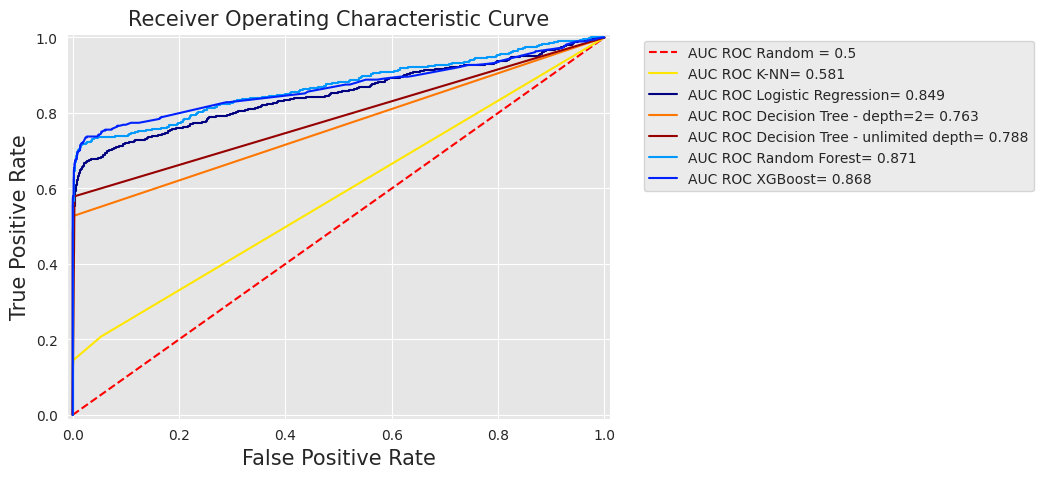

In [ ]:
# ROC Curve
roc_curve, ax = plt.subplots(1, 1, figsize=(7,5))
get_template_roc_curve(ax, title='Receiver Operating Characteristic Curve', fs=15)

true_labels = test_df['TX_FRAUD']
for classifier, dictionary in zip(classifiers_list, dictionaries_list):
    fraud_probs = dictionary['predictions_test']
    FPR_list, TPR_list, threshold = metrics.roc_curve(true_labels, fraud_probs)
    ROC_AUC = metrics.auc(FPR_list, TPR_list)
    ax.plot(FPR_list, TPR_list, 'b', color=colors[classifier], label = 'AUC ROC {0}= {1:0.3f}'.format(classifier, ROC_AUC))
    ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1))

The first point of the curve consists in predicting all transactions as genuine (threshold 1.1). The resulting TPR is zero (no detected fraud), and FPR is 0 (no false positive). 

The last point of the curve consists in predicting all transactions as fraudulent (threshold 0). The resulting TPR is one (all frauds detected), and FPR is 1 (all genuine transactions misclassified as frauds). 

The curves show that K-NN and decision trees have the lowest performances, while random forest, logistic regression, and boosting have similar performances. 

We can note that the curves for the two decision trees have only a few points: 
* the tree with depth two only has four leaves, therefore it only predicts four different values, and consequently has only four possible thresholds;

* the leaves of the tree with unlimited depth either predict a probability of 1 or a probability of 0 on the training set, therefore the model only has two possible thresholds.

ROC curves are relevant to get a sense of a classifier performance over the whole range of possible FPR. Their interest for fraud detection is however limited since an important goal of fraud detection is to keep the FPR very low. 


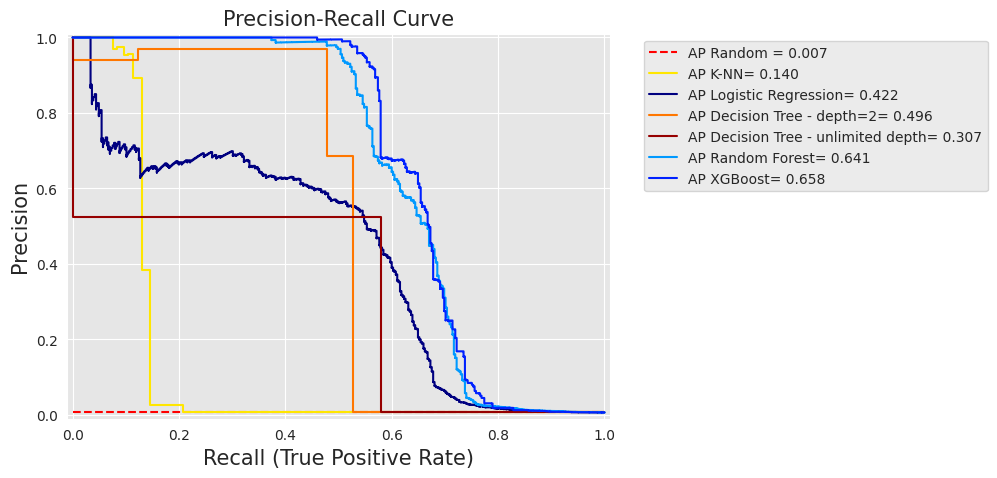

In [ ]:
# PR Curve 
pr_curve, ax = plt.subplots(1, 1, figsize=(7,5))
get_template_pr_curve(ax, "Precision-Recall Curve", fs=15, baseline=sum(test_df[output_feature])/len(test_df[output_feature]))

true_labels = test_df['TX_FRAUD']
for classifier, dictionary in zip(classifiers_list, dictionaries_list):
    fraud_probs = dictionary['predictions_test']
    precision, recall, threshold = metrics.precision_recall_curve(true_labels, fraud_probs)
    precision = precision[::-1]
    recall = recall[::-1]
    AP = metrics.average_precision_score(true_labels, fraud_probs)
    ax.step(recall, precision, 'b', color=colors[classifier], label='AP {0}= {1:0.3f}'.format(classifier, AP))
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1)) 

In order to better relate the ROC and PF curves, it is useful to mentally 'transpose' the PR curve in such a way that the x-axis represents the precision, and the y-axis represents the True Positive Rate. Once transposed, both curves represent the TPR on their y-axis, and one can note that the PR curve is actually a zoomed version of the ROC curves for very low values of the False Positive Rate.

The TPR for low FPR values is actually what matters in a fraud detection problem: the number of cards that can be manually checked by fraud investigators is in practice very limited. This also gives a different ordering of performances for the classifiers. For example, with ROC curves, decision trees with unlimited depth have a better AUC than a decision tree of depth two (0.788 versus 0.763, respectively). The performances are reversed when computed in terms of Average Precision (0.309 versus 0.496). 

While PR curves are useful to highlight the performances of fraud detection systems for low FPR values, they however remain difficult to interpret from an operational point of view. The next section addresses this issue, by discussing Precision Top- K metrics.
 

#### Precision Top-K metrics

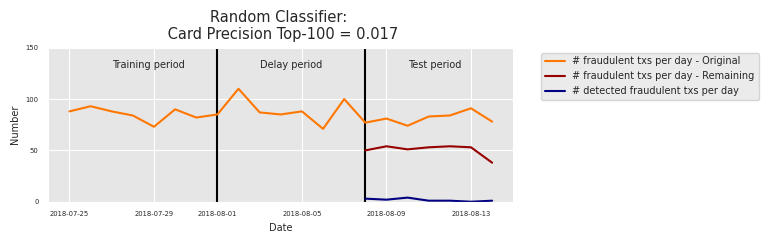

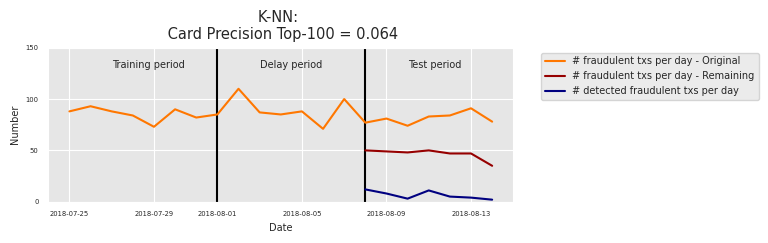

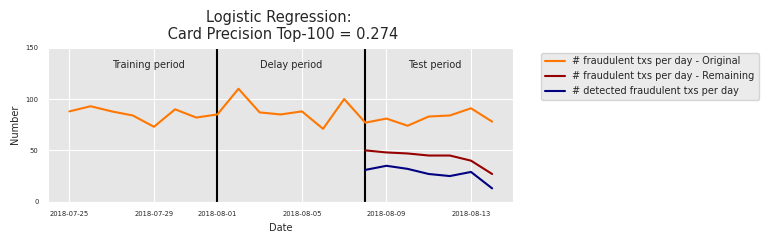

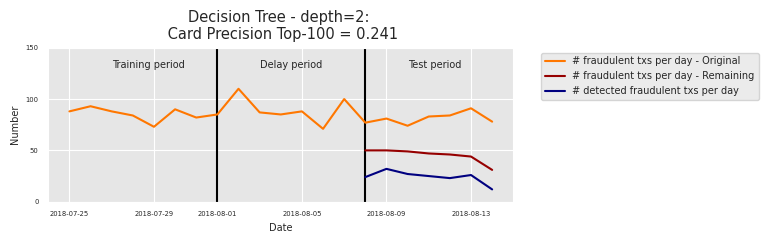

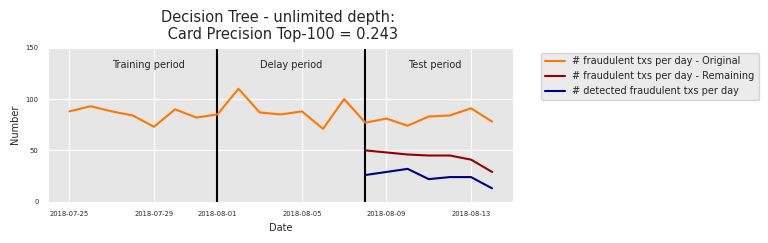

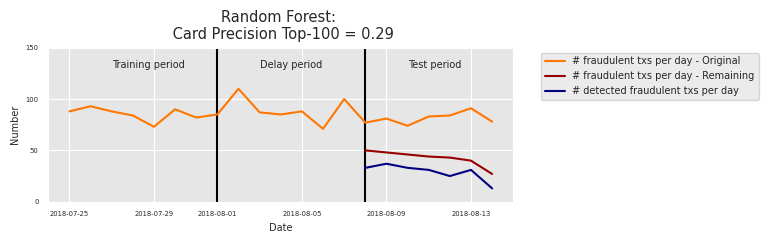

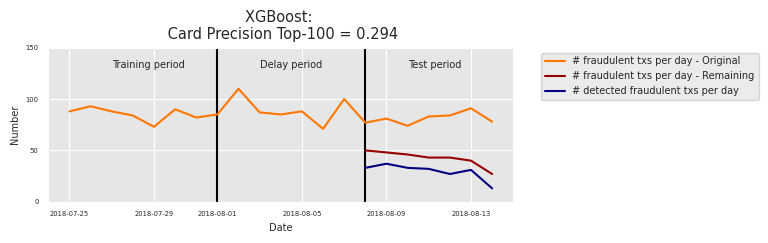

In [ ]:
classifiers_list.insert(0, 'Random Classifier')
dictionaries_list.insert(0, random_dictionary)

# Training period
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = 7
end_date_training = start_date_training+datetime.timedelta(days=delta_train - 1)

# Test period
start_date_test = start_date_training + datetime.timedelta(days=delta_train + delta_delay)
end_date_test = start_date_training + datetime.timedelta(days=delta_train + delta_delay + delta_test - 1)

cmap = plt.get_cmap('jet')
colors={'precision_top_k_per_day': cmap(0), 
        'nb_fraudulent_transactions_per_day': cmap(200),
        'nb_fraudulent_transactions_per_day_remaining': cmap(250)}

predictions_df = test_df
for classifier, dictionary in zip(classifiers_list, dictionaries_list):
    predictions_df['predictions'] = dictionary['predictions_test']
    nb_fraudulent_transactions_per_day_remaining,\
    precision_top_k_per_day_list,\
    mean_precision_top_k = card_precision_top_k(predictions_df, top_k=100)

    # Compute:
    # * the number of transactions per day
    # * the number of fraudulent transactions per day 
    # * the number of fraudulent cards per day
    tx_stats = get_tx_stats(transactions_df, start_date_df="2018-04-01")

    # Add the remaining number of fraudulent transactions for the last 7 days (test period)
    tx_stats.loc[14:20, 'nb_fraudulent_transactions_per_day_remaining'] = list(nb_fraudulent_transactions_per_day_remaining)
    # Add precision top k for the last 7 days (test period) 
    tx_stats.loc[14:20, 'precision_top_k_per_day'] = precision_top_k_per_day_list

    fraud_and_transactions_stats_fig, ax = plt.subplots(1, 1, figsize=(6,2))

    get_template_tx_stats(ax, fs=7,
                          start_date_training=start_date_training,
                          title= classifier + ': \n Card Precision Top-100 = ' + str(round(mean_precision_top_k,3)),
                          delta_train=delta_train,
                          delta_delay=delta_delay,
                          delta_test=delta_test,
                          ylim=150
                        )

    ax.plot(tx_stats['tx_date'], tx_stats['nb_fraudulent_transactions_per_day'], 'b', color=colors['nb_fraudulent_transactions_per_day'], label = '# fraudulent txs per day - Original')
    ax.plot(tx_stats['tx_date'], tx_stats['nb_fraudulent_transactions_per_day_remaining'], 'b', color=colors['nb_fraudulent_transactions_per_day_remaining'], label = '# fraudulent txs per day - Remaining')
    ax.plot(tx_stats['tx_date'], tx_stats['precision_top_k_per_day']*100, 'b', color=colors['precision_top_k_per_day'], label = '# detected fraudulent txs per day')
    ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1),fontsize=7)
    

classifiers_list.remove('Random Classifier')
dictionaries_list.remove(random_dictionary)

# **4. Imbalanced learning strategies**

In this section we will focus on the ML model obtaining the best threshold between good performance and low execution time, namely XGBoost. 

In [ ]:
DIR_INPUT = 'simulated-data-transformed/data/' 
BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"
transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)

In [ ]:
n_folds = 4   # validation folds

start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = delta_valid = delta_assessment = 7

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)

# Keep only the useful dataframe columns
compact_transactions_df = transactions_df[['CUSTOMER_ID', 'TX_FRAUD', 'TX_TIME_DAYS']]
card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=compact_transactions_df)

performance_metrics_list_grid = ['roc_auc', 'average_precision', 'card_precision@100']
performance_metrics_list = ['AUC ROC', 'Average precision', 'Card Precision@100']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100,
           }

## **4.1 Cost-sensitive learning**

Cost-sensitive learning is a subfield of machine learning that addresses classification problems where the misclassification costs are not equal, due to the fact that the goal is to detect events that are rare. 

A common practice consists in considering the misclassification costs as a hyperparameter to be identified through model selection. 

In [ ]:
classifier = xgboost.XGBClassifier()

# For the XGBoost classifier, the parameter `scale_pos_weight` controls 
# the balance of positive and negative weights, useful for unbalanced classes. 
parameters = {'clf__max_depth': [3], 'clf__n_estimators': [25], 'clf__learning_rate': [0.3],
              'clf__random_state': [0], 'clf__n_jobs': [1], 'clf__verbosity': [0],
              'clf__scale_pos_weight': list(np.arange(1, 11, 0.5))}  # default = 1 for balanced data

# Fit model and assess performances for all parameters
imbalanced_performance_df = model_selection_wrapper(transactions_df, classifier, 
                                          input_features, output_feature,
                                          parameters, scoring, 
                                          start_date_training_for_valid,
                                          start_date_training_for_test,
                                          n_folds=n_folds,
                                          delta_train=delta_train, 
                                          delta_delay=delta_delay, 
                                          delta_assessment=delta_assessment,
                                          performance_metrics_list_grid=performance_metrics_list_grid,
                                          performance_metrics_list=performance_metrics_list,
                                          n_jobs=1)

parameters_dict = dict(imbalanced_performance_df['Parameters'])
imbalanced_performance_df['Parameters summary'] = [parameters_dict[i]['clf__scale_pos_weight'] for i in range(len(parameters_dict))]

XGBoost
                                AUC ROC Average precision Card Precision@100
Best estimated parameters           6.0               1.0                1.0
Validation performance      0.88+/-0.01      0.698+/-0.02       0.289+/-0.02
Test performance           0.866+/-0.01      0.679+/-0.01       0.303+/-0.01
Optimal parameter(s)                2.0               1.5                7.0
Optimal test performance   0.873+/-0.01      0.679+/-0.01       0.306+/-0.01





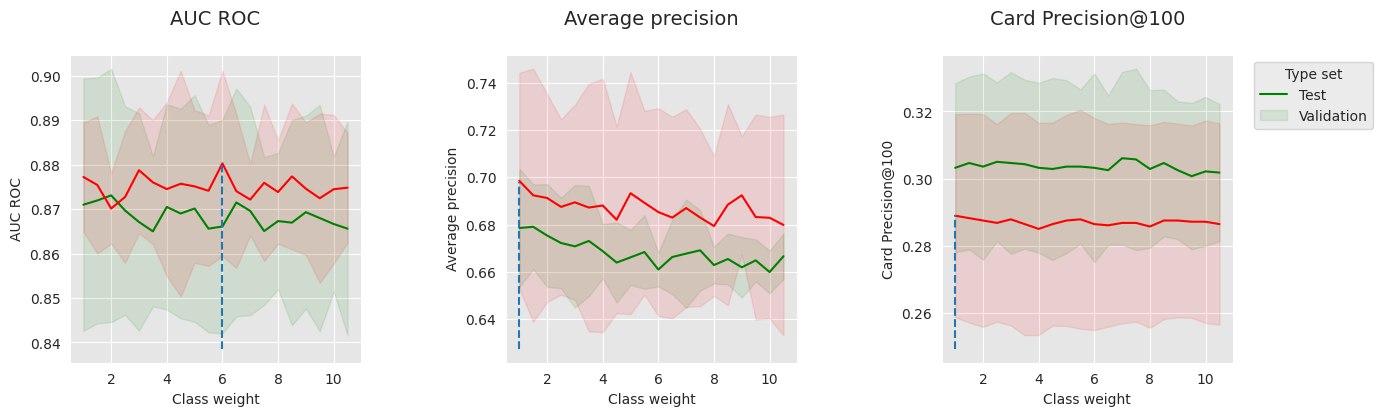

In [ ]:
print('XGBoost')
summary_performance_df = get_summary_performances(imbalanced_performance_df, parameter_column_name="Parameters summary")
print(summary_performance_df)
print('\n\n')
get_performances_plots(imbalanced_performance_df, 
                      performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                      expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                      parameter_name="Class weight",
                      summary_performances=summary_performance_df)

## **4.2 Resampling**

Numerous methods have been proposed for resampling imbalanced datasets, which can be categorized into three main strategies: 
* Oversampling consists in artificially increasing the proportion of samples from the minority class.
* Undersampling, on the contrary, consists in reducing the imbalance ratio by removing samples from the majority class (well-suited for large datasets).
* Hybridization of undersampling and oversampling.


### Utils

In [ ]:
def prequential_grid_search_with_sampler(transactions_df, 
                                         classifier, sampler_list,
                                         input_features, output_feature, 
                                         parameters, scoring, 
                                         start_date_training, 
                                         n_folds=4,
                                         expe_type='Test',
                                         delta_train=7, 
                                         delta_delay=7, 
                                         delta_assessment=7,
                                         performance_metrics_list_grid=['roc_auc'],
                                         performance_metrics_list=['AUC ROC'],
                                         n_jobs=-1):
    
    estimators = sampler_list.copy()
    estimators.extend([('clf', classifier)])
    
    pipe = imblearn.pipeline.Pipeline(estimators)
    
    prequential_split_indices = prequentialSplit(transactions_df,
                                                 start_date_training=start_date_training, 
                                                 n_folds=n_folds, 
                                                 delta_train=delta_train, 
                                                 delta_delay=delta_delay, 
                                                 delta_assessment=delta_assessment)
    
    grid_search = sklearn.model_selection.GridSearchCV(pipe, parameters, scoring=scoring, cv=prequential_split_indices, refit=False, n_jobs=n_jobs)
    
    X = transactions_df[input_features]
    y = transactions_df[output_feature]

    grid_search.fit(X, y)
    
    performances_df = pd.DataFrame()
    
    for i in range(len(performance_metrics_list_grid)):
        performances_df[performance_metrics_list[i]+' '+expe_type]=grid_search.cv_results_['mean_test_'+performance_metrics_list_grid[i]]
        performances_df[performance_metrics_list[i]+' '+expe_type+' Std']=grid_search.cv_results_['std_test_'+performance_metrics_list_grid[i]]

    performances_df['Parameters'] = grid_search.cv_results_['params']
    performances_df['Execution time'] = grid_search.cv_results_['mean_fit_time']
    
    return performances_df

In [ ]:
def model_selection_wrapper_with_sampler(transactions_df, 
                                         classifier, 
                                         sampler_list,
                                         input_features, output_feature,
                                         parameters, 
                                         scoring, 
                                         start_date_training_for_valid,
                                         start_date_training_for_test,
                                         n_folds=4,
                                         delta_train=7, 
                                         delta_delay=7, 
                                         delta_assessment=7,
                                         performance_metrics_list_grid=['roc_auc'],
                                         performance_metrics_list=['AUC ROC'],
                                         n_jobs=-1):

    # Get performances on the validation set using prequential validation
    performances_df_validation = prequential_grid_search_with_sampler(transactions_df, classifier, sampler_list,
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_valid,
                            n_folds=n_folds,
                            expe_type='Validation',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            n_jobs=n_jobs)
    
    # Get performances on the test set using prequential validation
    performances_df_test = prequential_grid_search_with_sampler(transactions_df, classifier, sampler_list,
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_test,
                            n_folds=n_folds,
                            expe_type='Test',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            n_jobs=n_jobs)
    
    # Bind the two resulting DataFrames
    performances_df_validation.drop(columns=['Parameters','Execution time'], inplace=True)
    performances_df = pd.concat([performances_df_test,performances_df_validation],axis=1)

    # And return as a single DataFrame
    return performances_df

### SMOTE oversampling

SMOTE oversamples the minority class by generating synthetic examples in the neighborhood of observed ones. The idea is to form new minority examples by interpolating between samples of the same class. This has the effect of creating clusters around each minority observation. By creating synthetic observations, the classifier builds larger decision regions that contain nearby instances from the minority class. SMOTE has been shown to improve the performances of a base classifier in many applications.

In [ ]:
classifier = xgboost.XGBClassifier()

# Define sampling strategy
sampler_list = [('sampler', imblearn.over_sampling.SMOTE())]

parameters = {'clf__max_depth': [3], 'clf__n_estimators': [25], 'clf__learning_rate': [0.3],
              'clf__random_state': [0], 'clf__n_jobs': [1], 'clf__verbosity': [0],
              'sampler__sampling_strategy':[0.01, 0.05, 0.1, 0.5, 1], 'sampler__random_state':[0]} 

# Fit model and assess performances for all parameters
smote_performance_df = model_selection_wrapper_with_sampler(transactions_df, classifier, sampler_list, 
                                                     input_features, output_feature,
                                                     parameters, scoring, 
                                                     start_date_training_for_valid,
                                                     start_date_training_for_test,
                                                     n_folds=n_folds,
                                                     delta_train=delta_train, 
                                                     delta_delay=delta_delay, 
                                                     delta_assessment=delta_assessment,
                                                     performance_metrics_list_grid=performance_metrics_list_grid,
                                                     performance_metrics_list=performance_metrics_list,
                                                     n_jobs=1)

parameters_dict = dict(smote_performance_df['Parameters'])
smote_performance_df['Parameters summary'] = [parameters_dict[i]['sampler__sampling_strategy'] for i in range(len(parameters_dict))]

XGBoost
                                AUC ROC Average precision Card Precision@100
Best estimated parameters          0.01              0.01               0.05
Validation performance      0.874+/-0.0      0.691+/-0.02       0.287+/-0.02
Test performance           0.875+/-0.02      0.679+/-0.02       0.306+/-0.01
Optimal parameter(s)               0.01              0.01               0.01
Optimal test performance   0.875+/-0.02      0.679+/-0.02       0.307+/-0.01





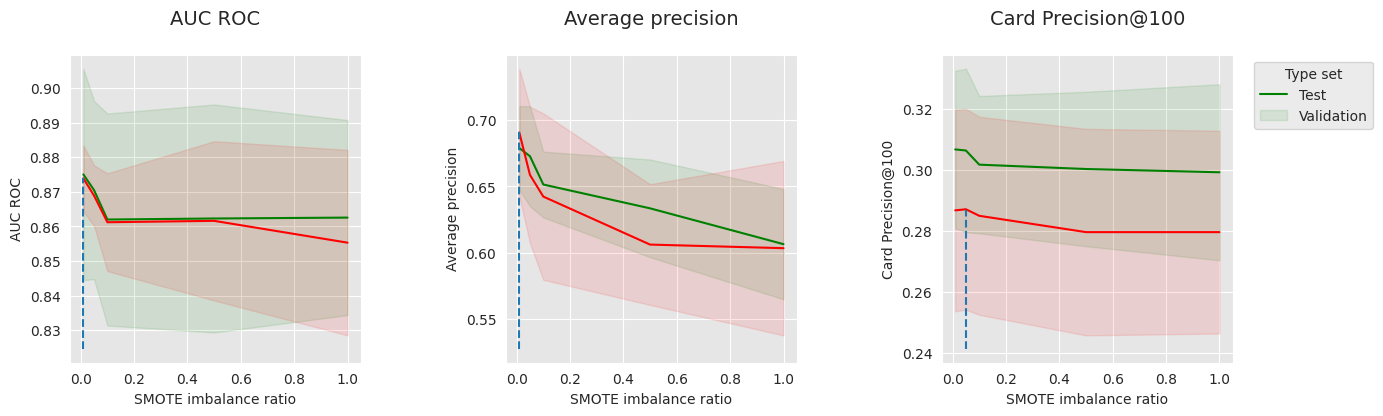

In [ ]:
print('XGBoost')
summary_performance_df = get_summary_performances(smote_performance_df, parameter_column_name="Parameters summary")
print(summary_performance_df)
print('\n\n')
get_performances_plots(smote_performance_df, 
                      performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                      expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                      parameter_name="SMOTE imbalance ratio",
                      summary_performances=summary_performance_df)

### Random undersampling 

Random undersampling (RUS) is a naive approach consisting in randomly removing samples from the majority class until the desired imbalance ratio is achieved. 

In [ ]:
classifier = xgboost.XGBClassifier()

# Define sampling strategy
sampler_list = [('sampler', imblearn.under_sampling.RandomUnderSampler())]

parameters = {'clf__max_depth': [3], 'clf__n_estimators': [25], 'clf__learning_rate': [0.3],
              'clf__random_state': [0], 'clf__n_jobs': [1], 'clf__verbosity': [0],
              'sampler__sampling_strategy':[0.01, 0.05, 0.1, 0.5, 1], 'sampler__random_state':[0]} 

# Fit models and assess performances for all parameters
rus_performance_df = model_selection_wrapper_with_sampler(transactions_df, classifier, sampler_list, 
                                                     input_features, output_feature,
                                                     parameters, scoring, 
                                                     start_date_training_for_valid,
                                                     start_date_training_for_test,
                                                     n_folds=n_folds,
                                                     delta_train=delta_train, 
                                                     delta_delay=delta_delay, 
                                                     delta_assessment=delta_assessment,
                                                     performance_metrics_list_grid=performance_metrics_list_grid,
                                                     performance_metrics_list=performance_metrics_list,
                                                     n_jobs=1)

parameters_dict = dict(rus_performance_df['Parameters'])
rus_performance_df['Parameters summary'] = [parameters_dict[i]['sampler__sampling_strategy'] for i in range(len(parameters_dict))]

XGBoost
                                AUC ROC Average precision Card Precision@100
Best estimated parameters          0.05              0.01                0.1
Validation performance     0.877+/-0.01      0.694+/-0.02        0.29+/-0.02
Test performance           0.871+/-0.01      0.681+/-0.01         0.3+/-0.01
Optimal parameter(s)               0.05              0.01               0.01
Optimal test performance   0.871+/-0.01      0.681+/-0.01       0.305+/-0.01





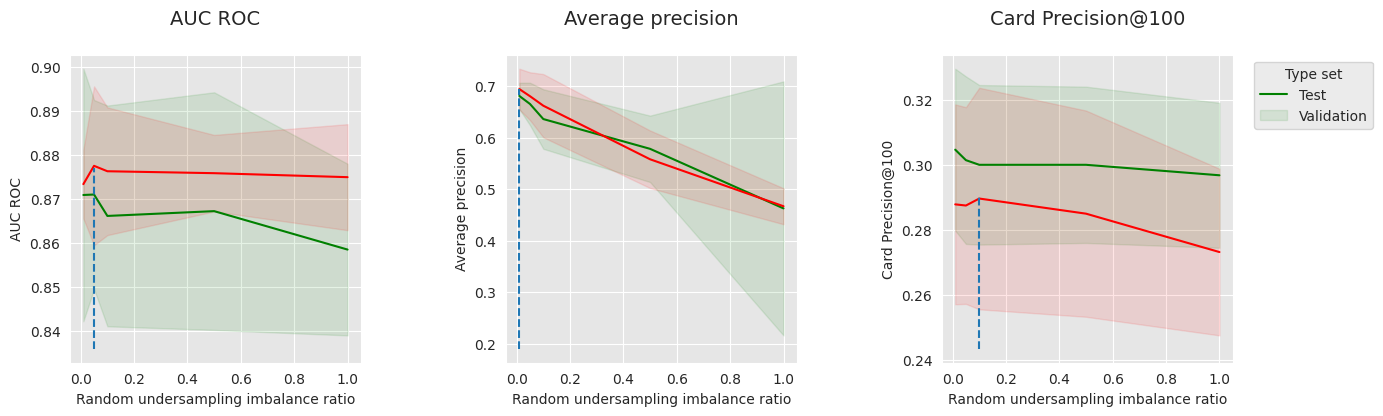

In [ ]:
print('XGBoost')
summary_performance_df = get_summary_performances(rus_performance_df, parameter_column_name="Parameters summary")
print(summary_performance_df)
print('\n\n')
get_performances_plots(rus_performance_df, 
                      performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                      expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                      parameter_name="Random undersampling imbalance ratio",
                      summary_performances=summary_performance_df)

### Edited Nearest Neighbor undersampling

The Edited Nearest Neighbor rule is an undersampling technique that removes samples from the majority class in overlapping regions of the dataset. It is based on a nearest neighbor rule, that removes majority class samples as follows:
* For each majority class sample, the k-nearest neighbors are found. If the majority of these samples are from the minority class, the majority class sample is removed.
* For each minority class sample, the k-nearest neighbors are found. If the majority of these samples are from the majority class, the majority class sample(s) is (are) removed.

The number of neighbors $k$ is by default set to $k=3$. It is worth noting that, contrary to RUS, the number of majority class samples that are removed depends on the degree of overlap between the two classes. The method does not allow to specify an imbalanced ratio. 


In [ ]:
classifier = xgboost.XGBClassifier()

# Define sampling strategy
sampler_list = [('sampler', imblearn.under_sampling.EditedNearestNeighbours())]

parameters = {'clf__max_depth': [3], 'clf__n_estimators': [25], 'clf__learning_rate': [0.3],
              'clf__random_state': [0], 'clf__n_jobs': [1], 'clf__verbosity': [0],
              'sampler__sampling_strategy': ['majority'], 'sampler__n_neighbors':[3, 5, 10, 30]} 

# Fit models and assess performances for all parameters
enn_performance_df = model_selection_wrapper_with_sampler(transactions_df, classifier, sampler_list, 
                                                     input_features, output_feature,
                                                     parameters, scoring, 
                                                     start_date_training_for_valid,
                                                     start_date_training_for_test,
                                                     n_folds=n_folds,
                                                     delta_train=delta_train, 
                                                     delta_delay=delta_delay, 
                                                     delta_assessment=delta_assessment,
                                                     performance_metrics_list_grid=performance_metrics_list_grid,
                                                     performance_metrics_list=performance_metrics_list,
                                                     n_jobs=1)

parameters_dict = dict(enn_performance_df['Parameters'])
enn_performance_df['Parameters summary'] = [parameters_dict[i]['sampler__n_neighbors'] for i in range(len(parameters_dict))]

XGBoost
                                AUC ROC Average precision Card Precision@100
Best estimated parameters            30                 3                 10
Validation performance      0.881+/-0.0      0.695+/-0.02       0.289+/-0.02
Test performance            0.87+/-0.01      0.678+/-0.01       0.302+/-0.01
Optimal parameter(s)                  5                 3                  5
Optimal test performance   0.872+/-0.02      0.678+/-0.01       0.303+/-0.01





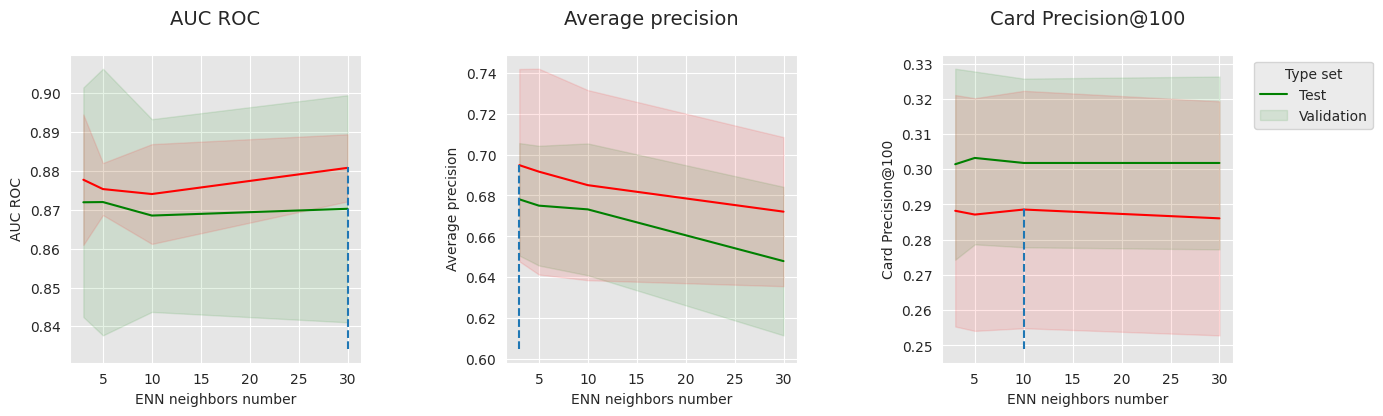

In [ ]:
print('XGBoost')
summary_performance_df = get_summary_performances(enn_performance_df, parameter_column_name="Parameters summary")
print(summary_performance_df)
print('\n\n')
get_performances_plots(enn_performance_df, 
                      performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                      expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                      parameter_name="ENN neighbors number",
                      summary_performances=summary_performance_df)

### Hybrid resampling: SMOTE oversampling and random undersampling.

In [ ]:
classifier = xgboost.XGBClassifier()

# Define sampling strategy
sampler_list = [('sampler1', imblearn.over_sampling.SMOTE()),
                ('sampler2', imblearn.under_sampling.RandomUnderSampler())]

parameters = {'clf__max_depth': [3], 'clf__n_estimators': [25], 'clf__learning_rate': [0.3],
              'clf__random_state': [0], 'clf__n_jobs': [1], 'clf__verbosity': [0],
              'sampler1__sampling_strategy':[0.01], 'sampler1__random_state':[0],
              'sampler2__sampling_strategy':[0.01, 0.05, 0.1, 0.5, 1], 'sampler2__random_state':[0]} 

# Fit models and assess performances for all parameters
hybrid_performance_df = model_selection_wrapper_with_sampler(transactions_df, classifier, sampler_list, 
                                                     input_features, output_feature,
                                                     parameters, scoring, 
                                                     start_date_training_for_valid,
                                                     start_date_training_for_test,
                                                     n_folds=n_folds,
                                                     delta_train=delta_train, 
                                                     delta_delay=delta_delay, 
                                                     delta_assessment=delta_assessment,
                                                     performance_metrics_list_grid=performance_metrics_list_grid,
                                                     performance_metrics_list=performance_metrics_list,
                                                     n_jobs=1)

parameters_dict = dict(hybrid_performance_df['Parameters'])
hybrid_performance_df['Parameters summary'] = [parameters_dict[i]['sampler2__sampling_strategy'] for i in range(len(parameters_dict))]

XGBoost
                                AUC ROC Average precision Card Precision@100
Best estimated parameters           0.1              0.01                0.1
Validation performance      0.88+/-0.01      0.691+/-0.02       0.289+/-0.02
Test performance           0.867+/-0.02      0.679+/-0.02       0.304+/-0.01
Optimal parameter(s)               0.01              0.01               0.01
Optimal test performance   0.875+/-0.02      0.679+/-0.02       0.307+/-0.01





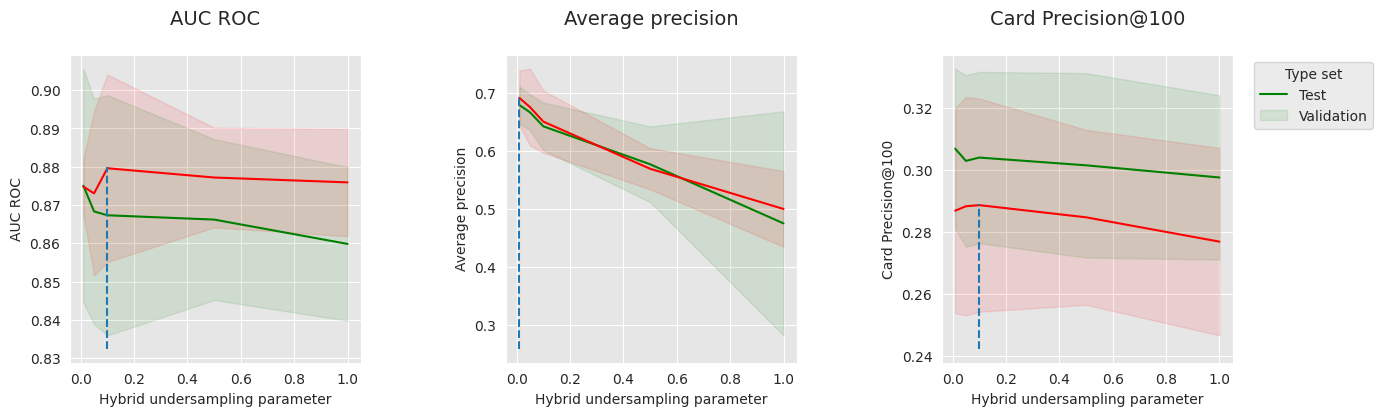

In [ ]:
print('XGBoost')
summary_performance_df = get_summary_performances(hybrid_performance_df, parameter_column_name="Parameters summary")
print(summary_performance_df)
print('\n\n')
get_performances_plots(hybrid_performance_df, 
                      performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                      expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                      parameter_name="Hybrid undersampling parameter",
                      summary_performances=summary_performance_df)

## **4.3 Parallel-based ensemble methods**

Ensemble methods consist in training multiple prediction models for the same prediction task, and in combining their outputs to make the final prediction. The prediction models making up an ensemble are referred to as *baseline learners*.

Ensemble methods can be broadly divided into:
* Parallel-based ensembles, in which each baseline learner is trained in parallel, using either a subset of the training data, a subset of the training features, or a combination of both. The two most popular techniques for parallel-based ensembles are Bagging and Random Forest.
* Iterative-based ensembles, in which the baseline classifiers are trained in sequence, with each learner in the sequence aiming at minimizing the prediction errors of the previous learner. One of the currently most widely-used implementations for boosting is XGBoost.

Bagging relies on the concept of *bootstrap aggregating*, which consists of training several baseline learners with different replicas of the original training set. The most usual practice is to randomly draw, with replacement, instances from the original dataset. The dataset size is maintained, meaning that approximately 63.2% of the instances are present in each sample (and some instances appear more than once).

**Balanced bagging** follows the same strategy as bagging, except that the training data is resampled using imbalanced learning techniques.

In [ ]:
classifier = imblearn.ensemble.BalancedBaggingClassifier()

parameters = {'clf__base_estimator':[sklearn.tree.DecisionTreeClassifier(max_depth=20,random_state=0)], 
              'clf__n_estimators':[100],
              'clf__sampling_strategy':[0.02, 0.05, 0.1, 0.5, 1], 
              'clf__bootstrap':[True],
              'clf__sampler':[imblearn.under_sampling.RandomUnderSampler()],
              'clf__random_state':[0],
              'clf__n_jobs':[-1]}


# Fit models and assess performances for all parameters
balanced_bagging_performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

parameters_dict = dict(balanced_bagging_performances_df['Parameters'])
balanced_bagging_performances_df['Parameters summary'] = [parameters_dict[i]['clf__sampling_strategy'] for i in range(len(parameters_dict))]

Balanced Bagging
                                AUC ROC Average precision Card Precision@100
Best estimated parameters           0.5              0.02                0.1
Validation performance       0.88+/-0.0      0.704+/-0.01       0.289+/-0.02
Test performance           0.879+/-0.01       0.68+/-0.01       0.305+/-0.01
Optimal parameter(s)                0.5              0.02                0.5
Optimal test performance   0.879+/-0.01       0.68+/-0.01       0.305+/-0.01





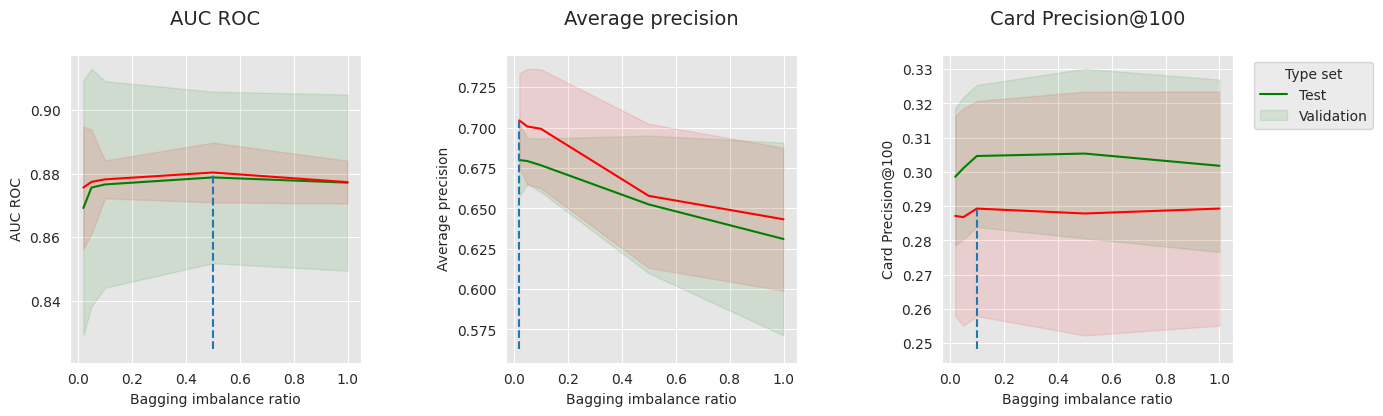

In [ ]:
print('Balanced Bagging')
summary_performance_df = get_summary_performances(balanced_bagging_performances_df, parameter_column_name="Parameters summary")
print(summary_performance_df)
print('\n\n')
get_performances_plots(balanced_bagging_performances_df, 
                      performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                      expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                      parameter_name="Bagging imbalance ratio",
                      summary_performances=summary_performance_df)

**Balanced Random Forest** was introduced in order to deal with imbalanced data. The procedure follows the same rationale as balanced bagging, and consists in building the baseline learners with balanced training sets. 

In [ ]:
classifier = imblearn.ensemble.BalancedRandomForestClassifier()

parameters = {'clf__max_depth':[20], 
              'clf__n_estimators':[100],
              'clf__sampling_strategy':[0.01, 0.05, 0.1, 0.5, 1], 
              'clf__random_state':[0],
              'clf__n_jobs':[-1]}

# Fit models and assess performances for all parameters
balanced_rf_performances_df = model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

parameters_dict = dict(balanced_rf_performances_df['Parameters'])
balanced_rf_performances_df['Parameters summary'] = [parameters_dict[i]['clf__sampling_strategy'] for i in range(len(parameters_dict))]

Balanced Bagging
                                AUC ROC Average precision Card Precision@100
Best estimated parameters          0.05              0.01               0.05
Validation performance      0.882+/-0.0      0.695+/-0.02       0.291+/-0.02
Test performance           0.872+/-0.02      0.677+/-0.01       0.302+/-0.01
Optimal parameter(s)                0.5              0.01               0.01
Optimal test performance   0.876+/-0.01      0.677+/-0.01       0.304+/-0.01





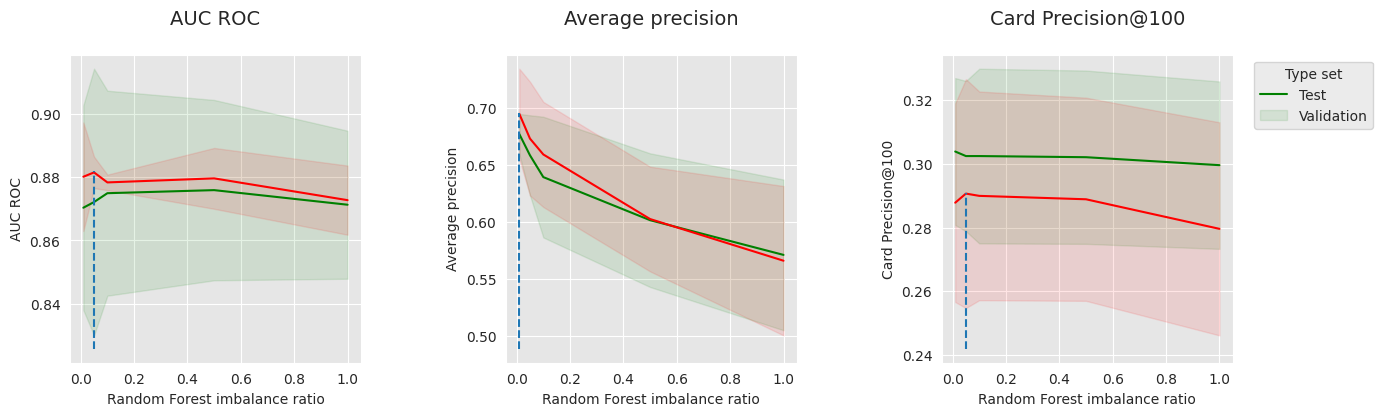

In [ ]:
print('Balanced Bagging')
summary_performance_df = get_summary_performances(balanced_rf_performances_df, parameter_column_name="Parameters summary")
print(summary_performance_df)
print('\n\n')
get_performances_plots(balanced_rf_performances_df, 
                      performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                      expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                      parameter_name="Random Forest imbalance ratio",
                      summary_performances=summary_performance_df)

Overall, the experimental results concerning imbalanced learning strategies do not provide remarkable improvements over the baseline ensembles. These results should however not lead to the conclusion that combining ensemble methods with imbalanced learning techniques has little benefit. Rather, they show that 

1. ensemble methods like random forest and XGBoost provide baselines that are difficult to improve

2. imbalanced learning techniques do change the decision boundary of the resulting classifier

3. imbalanced learning techniques might improve the predictive performances depending on which performance metric is used.     

To conclude, the best prediction performances were obtained with ensemble methods. Imbalanced learning techniques allowed to provide slight improvements in terms of AUC ROC or training times for balanced bagging and balanced random forest. XGBoost appeared as the best performing model in most of the experiments, illustrating its robustness to data imbalance scenarios across all performance metrics. The most likely explanation is that the residuals naturally give more weight to the minority class, thus acting like a cost-sensitive technique.

# **5. Deep Learning models in PyTorch**

In [ ]:
DIR_INPUT = 'simulated-data-transformed/data/' 
BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"
transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)

## **5.1 Feed-forward Neural Networks**

### Utils

**Dataset**

In [ ]:
class FraudDataset(torch.utils.data.Dataset):
    
    def __init__(self, x, y):
        'Initialization'
        self.x = x
        self.y = y

    def __len__(self):
        'Returns the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample index
        if self.y is not None:
            return self.x[index].to(DEVICE), self.y[index].to(DEVICE)
        else:
            return self.x[index].to(DEVICE)

In [ ]:
def prepare_generators_NN(train_df,valid_df,batch_size=64):
    # Convert data into FloatTensors (required in PyTorch)
    x_train = torch.FloatTensor(train_df[input_features].values)
    x_valid = torch.FloatTensor(valid_df[input_features].values)
    y_train = torch.FloatTensor(train_df[output_feature].values)
    y_valid = torch.FloatTensor(valid_df[output_feature].values)

    # Train and test dataset generators
    train_loader_params = {'batch_size': batch_size,
              'shuffle': True,
              'num_workers': 0}
    valid_loader_params = {'batch_size': batch_size,
              'num_workers': 0}

    training_set = FraudDataset(x_train, y_train)
    valid_set = FraudDataset(x_valid, y_valid)
    
    training_generator = torch.utils.data.DataLoader(training_set, **train_loader_params)
    valid_generator = torch.utils.data.DataLoader(valid_set, **valid_loader_params)
    
    return training_generator, valid_generator

In [ ]:
def prepare_generators_with_categorical_features(train_df,valid_df,input_categorical_features,batch_size=64):
    x_train = torch.FloatTensor(train_df[input_features].values)
    x_valid = torch.FloatTensor(valid_df[input_features].values)
    y_train = torch.FloatTensor(train_df[output_feature].values)
    y_valid = torch.FloatTensor(valid_df[output_feature].values)
    
    #categorical variables : encoding valid according to train
    encoder = sklearn.preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
    x_train_cat = encoder.fit_transform(train_df[input_categorical_features].values) + 1
    categorical_inputs_modalities = np.max(x_train_cat,axis=0)+1
    
    x_train_cat = torch.IntTensor(x_train_cat)
    x_valid_cat = torch.IntTensor(encoder.transform(valid_df[input_categorical_features].values) + 1)
    
    x_train = torch.cat([x_train,x_train_cat],axis=1)
    x_valid = torch.cat([x_valid,x_valid_cat],axis=1)
    
    train_loader_params = {'batch_size': batch_size,
              'shuffle': True,
              'num_workers': 0}
    valid_loader_params = {'batch_size': batch_size,
              'num_workers': 0}
    
    # Generators
    training_set = FraudDataset(x_train, y_train)
    valid_set = FraudDataset(x_valid, y_valid)
    
    training_generator = torch.utils.data.DataLoader(training_set, **train_loader_params)
    valid_generator = torch.utils.data.DataLoader(valid_set, **valid_loader_params)
    
    return training_generator,valid_generator, categorical_inputs_modalities

**Multi-Layer-Perceptron with Dropout**

In [ ]:
class SimpleFraudMLPWithDropout(torch.nn.Module):
    
        def __init__(self, input_size, hidden_size,p):
            super(SimpleFraudMLPWithDropout, self).__init__()
            # parameters
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.p = p
            
            #input to hidden
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            #hidden to output
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
            
            self.dropout = torch.nn.Dropout(self.p)
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.relu(hidden)
            
            hidden = self.dropout(hidden)
            
            output = self.fc2(hidden)
            output = self.sigmoid(output)
            
            return output

**Embeddings**

With neural networks, one can make use of embedding layers to encode categorical variables. More precisely, the idea is to let the neural network itself learn a representation of each modality of the categorical variable in a continuous vector space of dimension $k$, chosen by the practitioner. These representations can be learned end-to-end to make the feed-forward network optimal for the fraud detection task. They can also be learned with a different objective like predicting the sequences of countries visited by cardholders (unsupervised pre-training) and then later used for fraud detection, either with a neural network classifier or any other classifier.

Note that learning an embedding of dimension $k$ for a categorical feature is computationally equivalent to learning a classical fully connected layer that takes as input the one-hot encoding of the feature and outputs $k$ neurons.

In [ ]:
class FraudMLPWithEmbedding(torch.nn.Module):
    
        def __init__(self, categorical_inputs_modalities,numerical_inputs_size,embedding_sizes, hidden_size,p):
            super(FraudMLPWithEmbedding, self).__init__()
            # parameters
            self.categorical_inputs_modalities = categorical_inputs_modalities
            self.numerical_inputs_size = numerical_inputs_size
            self.embedding_sizes = embedding_sizes
            self.hidden_size  = hidden_size
            self.p = p
            
            assert len(categorical_inputs_modalities)==len(embedding_sizes), 'categorical_inputs_modalities and embedding_sizes must have the same length'
            
            #embedding layers
            self.emb = []
            for i in range(len(categorical_inputs_modalities)):
                self.emb.append(torch.nn.Embedding(int(categorical_inputs_modalities[i]), int(embedding_sizes[i])).to(DEVICE))
                
            
            #contenated inputs to hidden
            self.fc1 = torch.nn.Linear(self.numerical_inputs_size+int(np.sum(embedding_sizes)), self.hidden_size)
            self.relu = torch.nn.ReLU()
            #hidden to output
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
            
            self.dropout = torch.nn.Dropout(self.p)
            
        def forward(self, x):
            #we assume that x start with numerical features then categorical features
            inputs = [x[:,:self.numerical_inputs_size]]
            for i in range(len(self.categorical_inputs_modalities)):
                inputs.append(self.emb[i](x[:,self.numerical_inputs_size+i].to(torch.int64)))
            
            x = torch.cat(inputs,axis=1)
            
            
            hidden = self.fc1(x)
            hidden = self.relu(hidden)
            
            hidden = self.dropout(hidden)
            
            output = self.fc2(hidden)
            output = self.sigmoid(output)
            
            return output

**Training and testing**

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:
def training_loop(model,training_generator,valid_generator,optimizer,criterion,max_epochs=100,apply_early_stopping=True,patience=2,verbose=False):
    #Setting the model in training mode
    model.train()

    if apply_early_stopping:
        early_stopping = EarlyStopping(verbose=verbose,patience=patience)
    
    all_train_losses = []
    all_valid_losses = []
    
    #Training loop
    start_time=time.time()
    for epoch in range(max_epochs):
        model.train()
        train_loss=[]
        for x_batch, y_batch in training_generator:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()   
            train_loss.append(loss.item())
        
        #showing last training loss after each epoch
        all_train_losses.append(np.mean(train_loss))
        if verbose:
            print('')
            print('Epoch {}: train loss: {}'.format(epoch, np.mean(train_loss)))
        #evaluating the model on the test set after each epoch    
        valid_loss = evaluate_model(model,valid_generator,criterion)
        all_valid_losses.append(valid_loss)
        if verbose:
            print('valid loss: {}'.format(valid_loss))
        if apply_early_stopping:
            if not early_stopping.continue_training(valid_loss):
                if verbose:
                    print("Early stopping")
                break
        
    training_execution_time=time.time()-start_time
    return model,training_execution_time,all_train_losses,all_valid_losses

In [ ]:
def evaluate_model(model, generator, criterion):
    model.eval()
    batch_losses = []
    for x_batch, y_batch in generator:
        # Forward pass
        y_pred = model(x_batch)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        batch_losses.append(loss.item())
    mean_loss = np.mean(batch_losses)    
    return mean_loss 

In [ ]:
class EarlyStopping:
    
    def __init__(self, patience=2, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = np.Inf
    
    def continue_training(self,current_score):
        if self.best_score > current_score:
            self.best_score = current_score
            self.counter = 0
            if self.verbose:
                print("New best score:", current_score)
        else:
            self.counter+=1
            if self.verbose:
                print(self.counter, " iterations since best score.")
                
        return self.counter <= self.patience        

**Dataset and MLP for grid search**

In order to make grid search work, several aspects of our previous Python classes have to be adapted:
* The dataset has to expect arrays instead of tensors, so the conversion will be done within the dataset. 
* Classifiers in `sklearn` have two output probabilities (one for each class) that are complementary. Therefore, the output of `fc2` has to be changed from $1$ to $2$, and the activation to `softmax` (similar to the sigmoid activation but with a global normalization). 


In [ ]:
class FraudDatasetForPipe(torch.utils.data.Dataset):
    
    def __init__(self, x, y):
        'Initialization'
        self.x = torch.FloatTensor(x)
        self.y = None
        if y is not None:
            self.y = torch.LongTensor(y.values)
        

    def __len__(self):
        'Returns the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample index
        if self.y is not None:
            return self.x[index], self.y[index]
        else:
            return self.x[index], -1       

In [ ]:
class FraudMLP(torch.nn.Module):
    
        def __init__(self, hidden_size=100,num_layers=1,p=0, input_size=len(input_features)):
            super(FraudMLP, self).__init__()
            # parameters
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.p = p
            
            #input to hidden
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            
            self.fc_hidden=[]
            for i in range(num_layers-1):
                self.fc_hidden.append(torch.nn.Linear(self.hidden_size, self.hidden_size))
                self.fc_hidden.append(torch.nn.ReLU())
                
            #hidden to output
            self.fc2 = torch.nn.Linear(self.hidden_size, 2)
            self.softmax = torch.nn.Softmax()
            
            self.dropout = torch.nn.Dropout(self.p)
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.relu(hidden)             
            hidden = self.dropout(hidden)
            
            for layer in self.fc_hidden:
                hidden=layer(hidden)
                hidden = self.dropout(hidden)
            
            output = self.fc2(hidden)
            output = self.softmax(output)
            
            return output

### Model setting and training

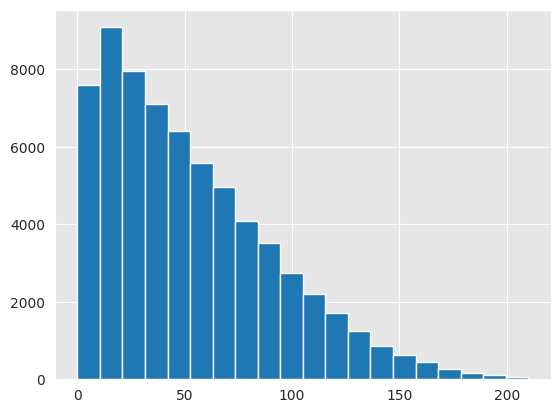

In [ ]:
# Setting the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = delta_valid = 7

start_date_training_with_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))

(train_df, valid_df) = get_train_test_set(transactions_df,start_date_training_with_valid,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

# Unscaled data example:
_ = plt.hist(train_df['TX_AMOUNT'].values, bins=20, range=(0, 210))

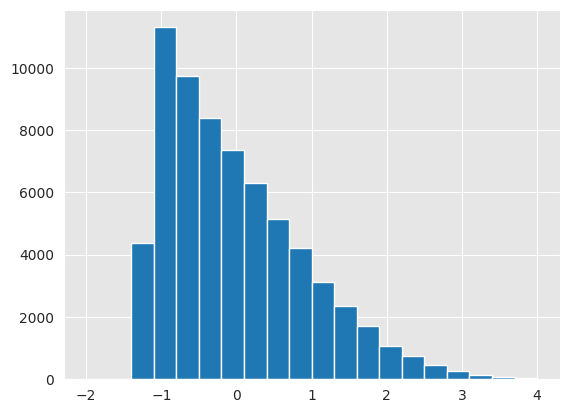

In [ ]:
# By default, scales input data
(train_df, valid_df) = scaleData(train_df, valid_df, input_features)

# Scaled data example:
_ = plt.hist(train_df['TX_AMOUNT'].values, bins=20, range=(-2,4))

In [ ]:
# Try to enable GPU
if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

Selected device is cuda


In [ ]:
# Allow reproducibility
SEED = 42

**Without embeddings**

In [ ]:
seed_everything(SEED)

# Train and validation sets
training_generator, valid_generator = prepare_generators_NN(train_df, 
                                                         valid_df, 
                                                         batch_size=64)

# Set the hidden layer to have 1000 neurons, and Dropout parameter=0.2
model = SimpleFraudMLPWithDropout(len(input_features), 1000, 0.2).to(DEVICE)

# Set Binary-Cross-Entropy as loss function
criterion = torch.nn.BCELoss().to(DEVICE)

# Optimization algorithm
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

# Put the model in `eval` mode in order to allow to measure
# it's initial loss on the test set before even training
print(model.eval())
print('\nInitial train loss:', evaluate_model(model, training_generator, criterion))
print('\nInitial valid loss:', evaluate_model(model, valid_generator, criterion))

SimpleFraudMLPWithDropout(
  (fc1): Linear(in_features=15, out_features=1000, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1000, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)

Initial train loss: 0.6762442687957282

Initial valid loss: 0.6750085101101568


Training

In [ ]:
model, training_execution_time, train_losses, valid_losses = training_loop(model,
                                                                           training_generator,
                                                                           valid_generator,
                                                                           optimizer,
                                                                           criterion,
                                                                           patience=3, # early-stopping
                                                                           verbose=True)


Epoch 0: train loss: 0.04602178569525181
valid loss: 0.02273925929661087
New best score: 0.02273925929661087

Epoch 1: train loss: 0.02706487230695232
valid loss: 0.022208596073737357
New best score: 0.022208596073737357

Epoch 2: train loss: 0.025317990107784124
valid loss: 0.02047716930681646
New best score: 0.02047716930681646

Epoch 3: train loss: 0.02461913286198116
valid loss: 0.02001814732424752
New best score: 0.02001814732424752

Epoch 4: train loss: 0.023493614993890636
valid loss: 0.019680407483199398
New best score: 0.019680407483199398

Epoch 5: train loss: 0.02319880496667356
valid loss: 0.019174265211493877
New best score: 0.019174265211493877

Epoch 6: train loss: 0.022045145627738013
valid loss: 0.019425576346636306
1  iterations since best score.

Epoch 7: train loss: 0.02195224992843633
valid loss: 0.01878275272405905
New best score: 0.01878275272405905

Epoch 8: train loss: 0.021739290216732876
valid loss: 0.01806430100238134
New best score: 0.01806430100238134

Ep

**With embeddings**

To test embedding layers, let us try to add extra categorical inputs and let the model learn embedding for them: we may add the raw terminal id and the day of the week as categorical input features.

In [ ]:
def weekday(tx_datetime):
    # Transform date into weekday (0 is Monday, 6 is Sunday)
    weekday = tx_datetime.weekday()
    return int(weekday)

train_df['TX_WEEKDAY'] = train_df.TX_DATETIME.apply(weekday)
valid_df['TX_WEEKDAY'] = valid_df.TX_DATETIME.apply(weekday)
input_categorical_features = ['TX_WEEKDAY','TERMINAL_ID']

In [ ]:
seed_everything(SEED)

# Train and validation sets
training_generator_emb, valid_generator_emb, categorical_inputs_modalities = prepare_generators_with_categorical_features(train_df, 
                                                                                                                  valid_df, 
                                                                                                                  input_categorical_features,
                                                                                                                  batch_size=64)
embedding_sizes = [10]*len(categorical_inputs_modalities)

# Set the hidden layer to have 1000 neurons, and Dropout parameter=0.2
model_emb = FraudMLPWithEmbedding(categorical_inputs_modalities, len(input_features), embedding_sizes, 1000, 0.2).to(DEVICE)

# Set Binary-Cross-Entropy as loss function
criterion_emb = torch.nn.BCELoss().to(DEVICE)

# Optimization algorithm
optimizer_emb = torch.optim.Adam(model_emb.parameters(), lr = 0.0001)

# Put the model in `eval` mode in order to allow to measure
# it's initial loss on the test set before even training
print(model_emb.eval())
print('\nInitial train loss:', evaluate_model(model_emb, training_generator_emb, criterion_emb))
print('\nInitial valid loss:', evaluate_model(model_emb, valid_generator_emb, criterion_emb))

FraudMLPWithEmbedding(
  (fc1): Linear(in_features=35, out_features=1000, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1000, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)

Initial train loss: 0.6348248532123821

Initial valid loss: 0.63541047781543


Training

In [ ]:
model_emb, training_execution_time_emb, train_losses_emb, valid_losses_emb = training_loop(model_emb,
                                                                                     training_generator_emb,
                                                                                     valid_generator_emb,
                                                                                     optimizer_emb,
                                                                                     criterion_emb,
                                                                                     patience=3, # early-stopping
                                                                                     verbose=True)


Epoch 0: train loss: 0.08257783652349138
valid loss: 0.029949616777451067
New best score: 0.029949616777451067

Epoch 1: train loss: 0.03377755699602684
valid loss: 0.024306780726857526
New best score: 0.024306780726857526

Epoch 2: train loss: 0.029305041930593734
valid loss: 0.02274640951702585
New best score: 0.02274640951702585

Epoch 3: train loss: 0.0272413829653604
valid loss: 0.02209012882422676
New best score: 0.02209012882422676

Epoch 4: train loss: 0.02631937183331107
valid loss: 0.021711508851228637
New best score: 0.021711508851228637

Epoch 5: train loss: 0.025383720055790565
valid loss: 0.021513494349446126
New best score: 0.021513494349446126

Epoch 6: train loss: 0.024610235518063586
valid loss: 0.021381852852786213
New best score: 0.021381852852786213

Epoch 7: train loss: 0.02403237375036331
valid loss: 0.021270186996820276
New best score: 0.021270186996820276

Epoch 8: train loss: 0.023389655090806146
valid loss: 0.02112058177692154
New best score: 0.0211205817769

**Comparison**

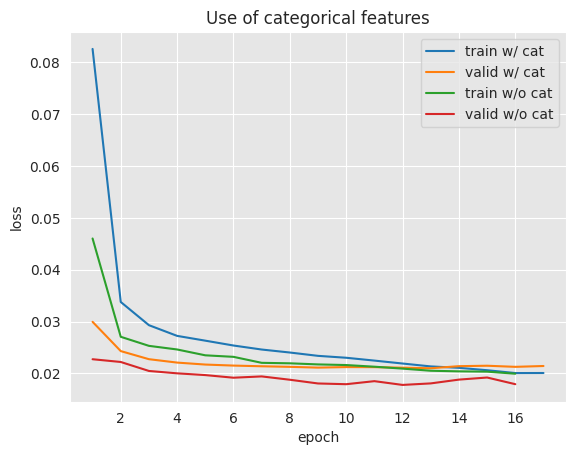

In [ ]:
plt.plot(np.arange(len(train_losses_emb))+1, train_losses_emb)
plt.plot(np.arange(len(valid_losses_emb))+1, valid_losses_emb)
plt.plot(np.arange(len(train_losses))+1, train_losses)
plt.plot(np.arange(len(valid_losses))+1, valid_losses)
plt.title('Use of categorical features')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train w/ cat','valid w/ cat','train w/o cat','valid w/o cat'])

The performance here is not necessarily better with the categorical features: they do not add value compared to the engineered features, at least for the fraud patterns in our categorical data.

However, embedding can also be interesting for interpretability. Indeed, at the end of training, one can extract `model.emb[i].weight`. Each row of this matrix represents the embedding vector of a given modality for the `i-th` categorical feature. This can be used to compute similarities between modalities. One can also reduce these vectors' dimensionality with TSNE or PCA and visualize all modalities on a 2D plane.

### Prequential grid search

Let us consider the following ranges:
* Batch size $[64, 128, 256]$
* Initial learning rate $[0.0001, 0.0005]$
* Dropout rate $[0, 0.2, 0.4]$
* Hidden layer dimension $[500]$
* Number of hidden layers $[1, 2]$
* Number of epochs $[10, 20, 40]$

To use the same procedure as in previous chapters (with GridSearchCV), we have to make the neural network compatible with `sklearn` functions. We will resort to the library `skorch`, which provides an `sklearn` wrapper for `PyTorch` modules. Also, early stopping won't be used, but instead the maximum number of epochs is fixed.

#### Setting

In [ ]:
!pip install skorch

In [ ]:
from skorch import NeuralNetClassifier

In [ ]:
n_folds = 4   # validation folds

start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = delta_valid = delta_assessment = 7

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)

# Keep only the useful dataframe columns
compact_transactions_df = transactions_df[['CUSTOMER_ID', 'TX_FRAUD', 'TX_TIME_DAYS']]
card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=compact_transactions_df)

performance_metrics_list_grid = ['roc_auc', 'average_precision', 'card_precision@100']
performance_metrics_list = ['AUC ROC', 'Average precision', 'Card Precision@100']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100,
           }

In [ ]:
net = NeuralNetClassifier(
    FraudMLP,
    max_epochs=2,
    lr=0.001,
    optimizer=torch.optim.Adam,
    batch_size=64,
    dataset=FraudDatasetForPipe,
    iterator_train__shuffle=True
)
net.set_params(train_split=False, verbose=0)

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.FraudMLP'>,
)

In [ ]:
seed_everything(SEED)
start_time=time.time()

parameters = {
    'clf__lr': [0.0001],
    'clf__batch_size': [64, 128, 256],
    'clf__max_epochs': [10, 20, 30],
    'clf__module__hidden_size': [500],
    'clf__module__num_layers': [2],
    'clf__module__p': [0, 0.2, 0.4],
    'clf__module__input_size': [int(len(input_features))],
}

performances_df = model_selection_wrapper(transactions_df, net, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=10)

parameters_dict = dict(performances_df['Parameters'])
performances_df['Parameters summary'] = [str(parameters_dict[i]['clf__batch_size'])+
                                         '/'+
                                         str(parameters_dict[i]['clf__max_epochs'])+
                                         '/'+
                                         str(parameters_dict[i]['clf__module__p'])    
                                         for i in range(len(parameters_dict))]

#### Analysis

If we fix the number of epochs to $20$ and the dropout level to $0.2$, the lower batch size leads to better results for average precision and card precision on the test set, whereas there is a sweet spot according to AUC-ROC. In fact, the optimal batch size is strongly connected to other optimizer parameters. Often, a larger batch size requires a larger number of epochs.

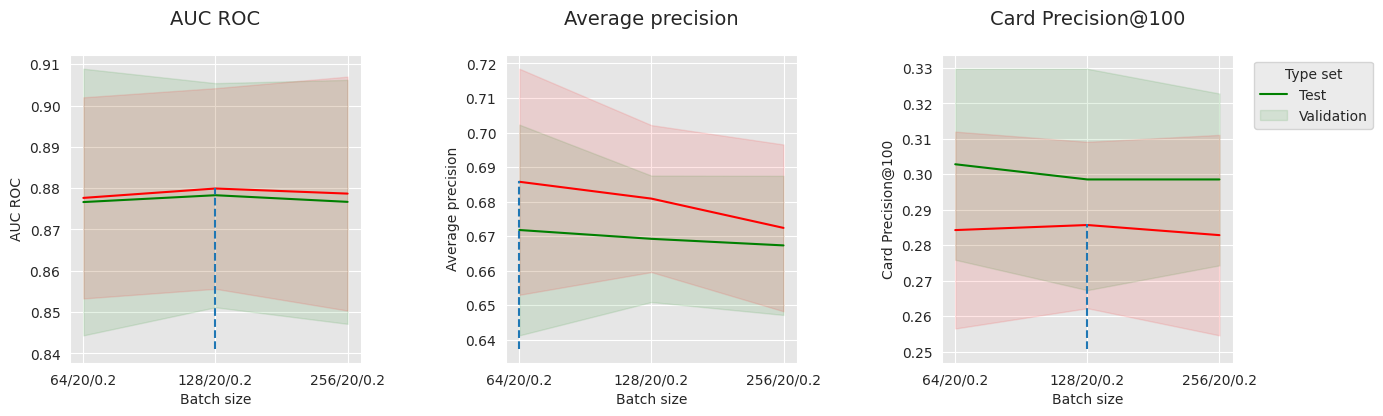

In [ ]:
batch_size_performances = performances_df[performances_df['Parameters'].apply(lambda x:x['clf__lr']== 0.001 and x['clf__module__hidden_size']==500 and x['clf__module__num_layers']==2 and x['clf__module__p']==0.2 and x['clf__max_epochs']==20).values]
summary_batch_size_performances = get_summary_performances(batch_size_performances, parameter_column_name="Parameters summary")
indexes_summary = summary_batch_size_performances.index.values
indexes_summary[0] = 'Best estimated parameters'
summary_batch_size_performances.rename(index = dict(zip(np.arange(len(indexes_summary)),indexes_summary)))
get_performances_plots(batch_size_performances, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Batch size",
                       summary_performances=summary_batch_size_performances)

The optimal number of epochs also depends on the metric and has a sweet spot strongly connected to the choice of other hyperparameters.

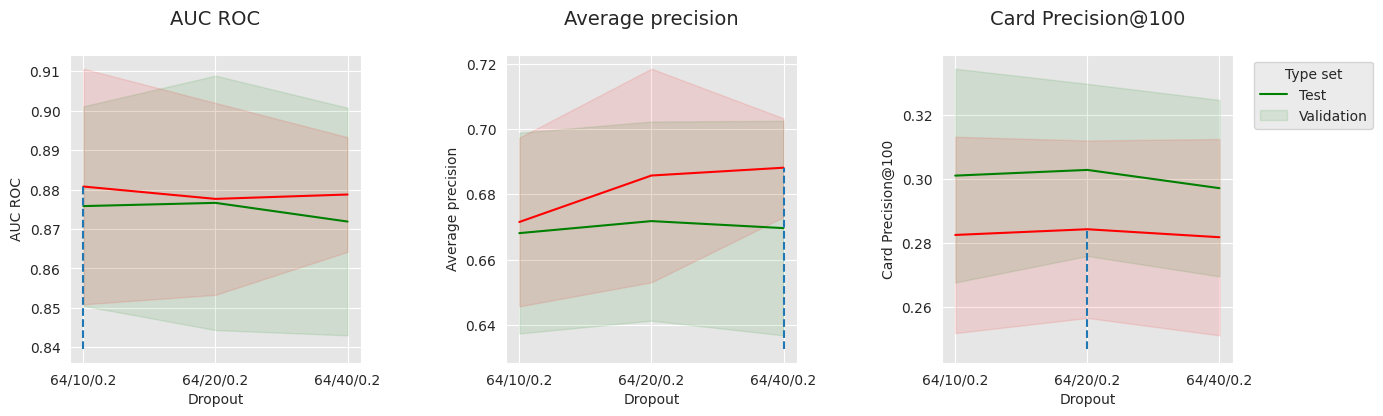

In [ ]:
max_epochs_performances = performances_df[performances_df['Parameters'].apply(lambda x:x['clf__lr']== 0.001 and x['clf__module__hidden_size']==500 and x['clf__module__num_layers']==2 and x['clf__module__p']==0.2 and x['clf__batch_size']==64).values]
summary_max_epochs_performances = get_summary_performances(max_epochs_performances, parameter_column_name="Parameters summary")
indexes_summary = summary_max_epochs_performances.index.values
indexes_summary[0] = 'Best estimated parameters'
summary_max_epochs_performances.rename(index = dict(zip(np.arange(len(indexes_summary)),indexes_summary)))
get_performances_plots(max_epochs_performances, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Dropout",
                       summary_performances=summary_max_epochs_performances)

When the dropout value is too high ($0.4$), it can deteriorate the results, e.g. by limiting the fitting power or by requiring a larger number of epochs.

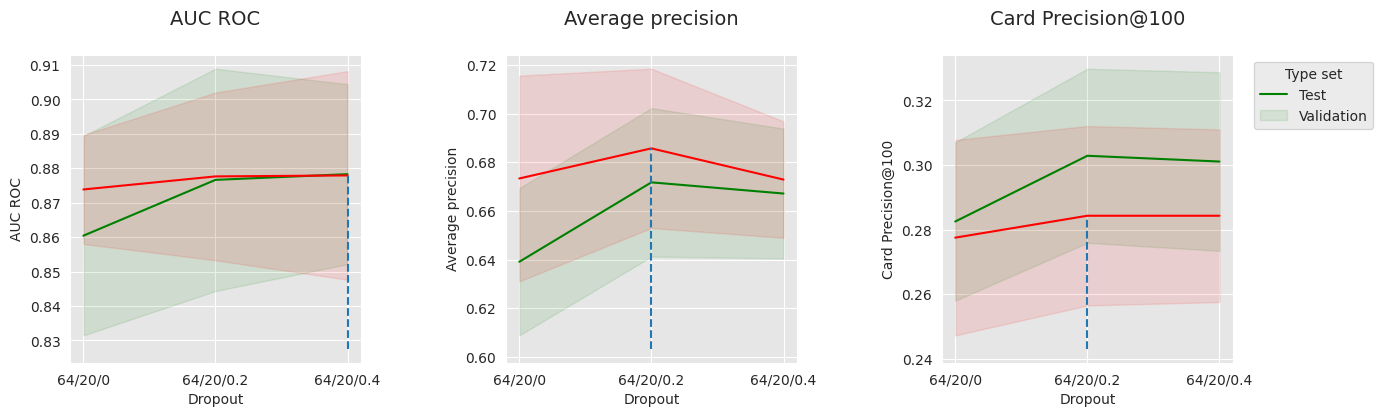

In [ ]:
dropout_performances = performances_df[performances_df['Parameters'].apply(lambda x:x['clf__lr']== 0.001 and x['clf__module__hidden_size']==500 and x['clf__module__num_layers']==2 and x['clf__max_epochs']==20 and x['clf__batch_size']==64).values]
summary_dropout_performances = get_summary_performances(dropout_performances, parameter_column_name="Parameters summary")
indexes_summary = summary_dropout_performances.index.values
indexes_summary[0] = 'Best estimated parameters'
summary_dropout_performances.rename(index = dict(zip(np.arange(len(indexes_summary)),indexes_summary)))
get_performances_plots(dropout_performances, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Dropout",
                       summary_performances=summary_dropout_performances)

## **5.2 Autoencoders for anomaly detection**

Fraud detection can be performed with both supervised and **unsupervised learning** techniques, as it is a special instance of a broader problem referred to as anomaly detection or outlier detection. The latter generally includes techniques to identify items that are rare or differ significantly from the "normal" behavior, observable in the majority of the data. Therefore, rare events or outliers can be detected with unsupervised techniques that learn the normality and which are able to estimate discrepancy to this normality. 

**Semi-supervised learning** techniques are in between the supervised and unsupervised cases and can learn from both unlabeled and labeled data to detect fraudulent transactions. 

An autoencoder can therefore be considered as an unsupervised technique for fraud detection because it can be used to model the normal behavior of data and detect outliers using the reconstruction error as an indicator. In particular, one way to do so is to train it to globally reconstruct transactions in a dataset. The normal trend that is observed in the majority of transactions will be better approximated than rare events. Therefore, the reconstruction error of "normal" data will be lower than the reconstruction error of outliers.

Other than unsupervised anomaly detection, an autoencoder can simply be used as a general **representation learning** method for credit card transaction data. In a more complex manner than PCA, an autoencoder will learn a transformation from the original feature space to a representation space with new variables that encodes all the useful information to reconstruct the original data. 

If the dimension of the code is chosen to be 2 or 3, one can visualize the transaction in the novel 2D/3D space. Otherwise, the code can also be used for other purposes, as:

* Clustering. Clustering can be performed on the code instead of the original features. Groups learned from the clustering can be useful to characterize the types of behaviors of consumers or fraudsters.
* Additional or replacement variables. The code can be used as replacement variables, or additional variables, to train any supervised learning model for credit card fraud detection. 


### Utils

**Dataset**

The autoencoder has the same input as the baseline feed-forward neural network but a different output. Instead of the fraud/genuine label, its target will be the same as the input. Therefore, the experiments here will not rely on the `FraudDataset` defined before but on a new Dataset: `FraudDatasetUnsupervised`, which only receives the descriptive features of the transaction `x` and returns it as both input and output. 

In [ ]:
class FraudDatasetUnsupervised(torch.utils.data.Dataset):
    
    def __init__(self, x,output=True):
        'Initialization'
        self.x = x
        self.output = output

    def __len__(self):
        'Returns the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample index
        item = self.x[index].to(DEVICE)
        if self.output:
            return item, item
        else:
            return item

In [ ]:
def prepare_generators_AE(train_df,valid_df,batch_size=64):
    # Convert data into FloatTensors (required in PyTorch)
    x_train = torch.FloatTensor(train_df[input_features].values)
    x_valid = torch.FloatTensor(valid_df[input_features].values)

    # Train and test dataset generators
    train_loader_params = {'batch_size': batch_size,
              'shuffle': True,
              'num_workers': 0}
    valid_loader_params = {'batch_size': batch_size,
              'num_workers': 0}

    training_set = FraudDatasetUnsupervised(x_train)
    valid_set = FraudDatasetUnsupervised(x_valid)
    
    training_generator = torch.utils.data.DataLoader(training_set, **train_loader_params)
    valid_generator = torch.utils.data.DataLoader(valid_set, **valid_loader_params)
    
    return training_generator, valid_generator

**Autoencoder**

In [ ]:
class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.relu = torch.nn.ReLU()   
            
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.relu(hidden)
            
            code = self.fc2(hidden)
            code = self.relu(code)
 
            hidden = self.fc3(code)
            hidden = self.relu(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

**Training and testing**

In [ ]:
# Compute the MSE for each sample provided by a generator:
def per_sample_mse(model, generator):
    
    model.eval()
    criterion = torch.nn.MSELoss(reduction="none")
    batch_losses = []
    
    for x_batch, y_batch in generator:
        # Forward pass
        y_pred = model(x_batch)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        loss_app = list(torch.mean(loss,axis=1).detach().cpu().numpy())
        batch_losses.extend(loss_app)
    
    return batch_losses

**Representation learning**

In [ ]:
# Obtain the transactions 2D-representation from the encoder part alone:
# the idea is to simply apply the first two layers of the pre-trained Autoencoder.
def compute_representation(x, model):
    x_representation = model.fc1(x)
    x_representation = model.relu(x_representation)
    x_representation = model.fc2(x_representation)
    x_representation = model.relu(x_representation)
    return x_representation

### Unsupervised learning

In [ ]:
# Setting the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = delta_valid = 7

start_date_training_with_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))

(train_df, valid_df) = get_train_test_set(transactions_df,start_date_training_with_valid,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

(train_df, valid_df) = scaleData(train_df, valid_df, input_features)

In [ ]:
# Try to enable GPU
if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

Selected device is cuda


In [ ]:
# Allow reproducibility
SEED = 42

In [ ]:
seed_everything(SEED)

# Train and validation sets
training_generator, valid_generator = prepare_generators_AE(train_df, 
                                                         valid_df, 
                                                         batch_size=64)

# Set the intermediate and representation layers to have 100 and 20 neurons, respectively
model = SimpleAutoencoder(len(input_features), 100, 20).to(DEVICE)

# Set Mean-Squared_error as loss function
criterion = torch.nn.MSELoss().to(DEVICE)

# Optimization algorithm
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
model, training_execution_time, train_losses, valid_losses = training_loop(model,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        verbose=True)


Epoch 0: train loss: 0.44572421743126717
valid loss: 0.11789110044394034
New best score: 0.11789110044394034

Epoch 1: train loss: 0.08445226696870124
valid loss: 0.044737992832650904
New best score: 0.044737992832650904

Epoch 2: train loss: 0.03813445617410979
valid loss: 0.028129150675701313
New best score: 0.028129150675701313

Epoch 3: train loss: 0.02394554824132052
valid loss: 0.016839706644293715
New best score: 0.016839706644293715

Epoch 4: train loss: 0.01385711675890887
valid loss: 0.009604522868319124
New best score: 0.009604522868319124

Epoch 5: train loss: 0.007683140128881209
valid loss: 0.00534085091305235
New best score: 0.00534085091305235

Epoch 6: train loss: 0.00527885537590105
valid loss: 0.00411556290406632
New best score: 0.00411556290406632

Epoch 7: train loss: 0.004053266167179477
valid loss: 0.003135803211454933
New best score: 0.003135803211454933

Epoch 8: train loss: 0.003077904276979863
valid loss: 0.0025029082204942985
New best score: 0.0025029082204

We can check that frauds are less well reconstructed than genuine transactions:

In [ ]:
x_train = torch.FloatTensor(train_df[input_features].values)
x_valid = torch.FloatTensor(valid_df[input_features].values)
y_train = torch.FloatTensor(train_df[output_feature].values)
y_valid = torch.FloatTensor(valid_df[output_feature].values)

training_set = FraudDatasetUnsupervised(x_train)
valid_set = FraudDatasetUnsupervised(x_valid)

losses = per_sample_mse(model, valid_generator)
genuine_losses = np.array(losses)[y_valid.cpu().numpy() == 0]
fraud_losses = np.array(losses)[y_valid.cpu().numpy() == 1]
print("Average fraud reconstruction error:", round(np.mean(fraud_losses), 5))
print("Average genuine reconstruction error:", round(np.mean(genuine_losses), 5))

Average fraud reconstruction error: 0.00137
Average genuine reconstruction error: 6e-05


#### Comparison with Isolation Forest

Isolation Forest is a state-of-the-art unsupervised anomaly detection technique that relies on tree-based models. It computes, for each sample of data, an anomaly score that reflects how atypical the sample is. In order to calculate this score, the algorithm tries to isolate the sample from the rest of the dataset recursively: it chooses a random cutoff (pair feature-threshold), and evaluates if it allows the sample at hand to be isolated. If so, the algorithm stops. Otherwise, it adds another cutoff, and repeats the process until the sample is isolated from the rest. This recursive data partitioning can be represented as a decision tree and the number of cutoffs necessary to isolate a sample can be considered as the anomaly score. The lower the number of cutoffs (i.e. the easier it is to isolate the data point), the more likely the sample is to be an outlier.

In [ ]:
if_classifier = sklearn.ensemble.IsolationForest(random_state=SEED, n_estimators=10)
if_classifier.fit(train_df[input_features])

In [ ]:
predictions_ae = valid_df
predictions_ae['predictions'] = losses
ae_performance = performance_assessment(predictions_ae, top_k_list=[100])

predictions_if = valid_df
predictions_if['predictions'] = -if_classifier.score_samples(valid_df[input_features])
if_performance = performance_assessment(predictions_if, top_k_list=[100])

summary = pd.concat([ae_performance, if_performance], axis=0)
summary.index = ['Autoencoder', 'Isolation Forest']
summary

AUC ROC  Average precision  Card Precision@100
Autoencoder         0.840              0.163                0.20
Isolation Forest    0.808              0.164                0.19

We can see that this state-of-the-art unsupervised baseline provides performances that are close (slightly lower) to those of the autoencoder.

### Representation learning

After training, one can use the encoder part alone to obtain representations of the transactions for visualization or clustering purposes. For that, let us train an autoencoder with a code dimension of $2$.

In [ ]:
seed_everything(SEED)

# Train and validation sets
training_generator, valid_generator = prepare_generators_AE(train_df, 
                                                         valid_df, 
                                                         batch_size=64)

# Set the intermediate and representation layers to have 100 and 20 neurons, respectively
model_representation = SimpleAutoencoder(len(input_features), 100, 2).to(DEVICE)

# Set Mean-Squared_error as loss function
criterion = torch.nn.MSELoss().to(DEVICE)

# Optimization algorithm
optimizer = torch.optim.Adam(model_representation.parameters(), lr = 0.0001)

In [ ]:
model_representation, training_execution_time, train_losses, valid_losses = training_loop(model_representation,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=300,
                                                                        verbose=True)


Epoch 0: train loss: 0.7699023189154911
valid loss: 0.5805507388922686
New best score: 0.5805507388922686

Epoch 1: train loss: 0.5995249582123346
valid loss: 0.5214713649345878
New best score: 0.5214713649345878

Epoch 2: train loss: 0.5190003914028463
valid loss: 0.47640630405783
New best score: 0.47640630405783

Epoch 3: train loss: 0.49128978937351453
valid loss: 0.46462850756332524
New best score: 0.46462850756332524

Epoch 4: train loss: 0.48287230821230215
valid loss: 0.4596672740790362
New best score: 0.4596672740790362

Epoch 5: train loss: 0.4774160735864712
valid loss: 0.4549810468824835
New best score: 0.4549810468824835

Epoch 6: train loss: 0.47170336154177356
valid loss: 0.44981633833523005
New best score: 0.44981633833523005

Epoch 7: train loss: 0.46371516710713534
valid loss: 0.44344577893533343
New best score: 0.44344577893533343

Epoch 8: train loss: 0.45431947209525064
valid loss: 0.4363586134597903
New best score: 0.4363586134597903

Epoch 9: train loss: 0.446179

Original train set shape:  torch.Size([66928, 15])
Compressed train set shape:  (66928, 2)


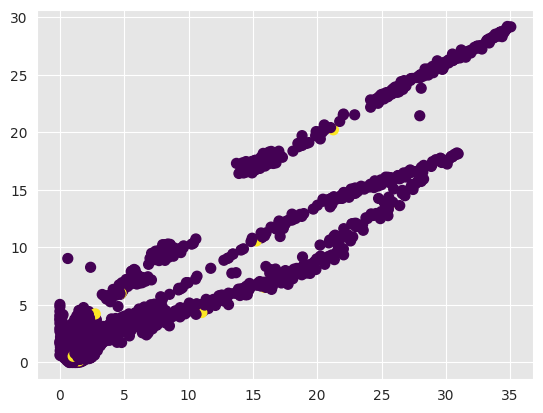

In [ ]:
x_train_representation = []
for x_batch, y_batch in training_generator: 
    x_train_representation.append(compute_representation(x_batch, model_representation).detach().cpu().numpy())

x_train_representation = np.vstack(x_train_representation)
print('Original train set shape: ', x_train.shape)
print('Compressed train set shape: ', x_train_representation.shape)

# Genuine --> violet
# Fraud --> yellow
plt.scatter(x_train_representation[:, 0], x_train_representation[:, 1], c=y_train.numpy(), s=50, cmap='viridis')

**Clustering**

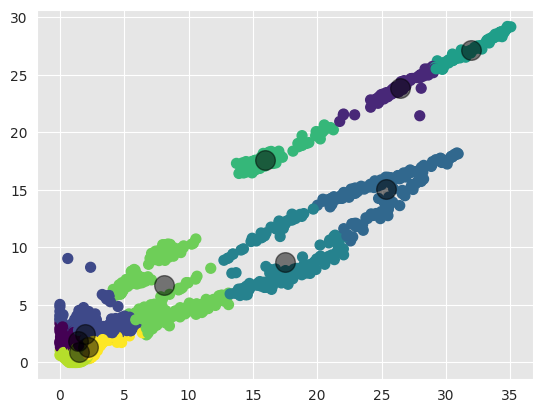

In [ ]:
kmeans = sklearn.cluster.KMeans(n_clusters=10, random_state=SEED)
kmeans.fit(x_train_representation)
y_kmeans = kmeans.predict(x_train_representation)

plt.scatter(x_train_representation[:, 0], x_train_representation[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

### Semi-supervised learning

Finally, the autoencoder can be used in a semi-supervised credit card fraud detection system. The autoencoder will be trained on all available labeled and unlabeled data. Then, we will combine it with a supervised neural network trained only on labeled data. The combination can be done by by providing the unsupervised risk score from the autoencoder (reconstruction error) as an additional variable to the supervised model.

In [ ]:
model

SimpleAutoencoder(
  (relu): ReLU()
  (fc1): Linear(in_features=15, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=15, bias=True)
)

In [ ]:
train_reconstruction = per_sample_mse(model, training_generator)
valid_reconstruction = per_sample_mse(model, valid_generator)

train_df['reconstruction_error'] = train_reconstruction
valid_df['reconstruction_error'] = valid_reconstruction

# Rescale the reconstruction error
input_features_new = input_features + ['reconstruction_error']
(train_df, valid_df) = scaleData(train_df, valid_df, ['reconstruction_error'])

x_train_new = torch.FloatTensor(train_df[input_features_new].values)
x_valid_new = torch.FloatTensor(valid_df[input_features_new].values)

training_set_supervised_new = FraudDataset(x_train_new.to(DEVICE), y_train.to(DEVICE))
valid_set_supervised_new = FraudDataset(x_valid_new.to(DEVICE), y_valid.to(DEVICE))

train_loader_params = {'batch_size': 64, 'shuffle': True, 'num_workers': 0}
valid_loader_params = {'batch_size': 64, 'num_workers': 0}
    
training_generator_supervised_ae = torch.utils.data.DataLoader(training_set_supervised_new, **train_loader_params)
valid_generator_supervised_ae = torch.utils.data.DataLoader(valid_set_supervised_new, **valid_loader_params)

In [ ]:
seed_everything(SEED)

model_supervised_ae = SimpleFraudMLPWithDropout(len(input_features_new), 100, 0.2).to(DEVICE)
optimizer_supervised_ae = torch.optim.Adam(model_supervised_ae.parameters(), lr=0.0001)
criterion_supervised_ae = torch.nn.BCELoss().to(DEVICE)

In [ ]:
model_supervised_ae, training_execution_time, train_losses_supervised_ae, valid_losses_supervised_ae = training_loop(model_supervised_ae,
                                                                        training_generator_supervised_ae,
                                                                        valid_generator_supervised_ae,
                                                                        optimizer_supervised_ae,
                                                                        criterion_supervised_ae,
                                                                        verbose=True)


Epoch 0: train loss: 0.3253989335413075
valid loss: 0.11777601240436887
New best score: 0.11777601240436887

Epoch 1: train loss: 0.08696832587981657
valid loss: 0.05067969434411148
New best score: 0.05067969434411148

Epoch 2: train loss: 0.055124867457298145
valid loss: 0.037264089029831964
New best score: 0.037264089029831964

Epoch 3: train loss: 0.04528284414064132
valid loss: 0.03201343377777299
New best score: 0.03201343377777299

Epoch 4: train loss: 0.040451249952675565
valid loss: 0.028887938030186248
New best score: 0.028887938030186248

Epoch 5: train loss: 0.03603960665024774
valid loss: 0.026852175141710156
New best score: 0.026852175141710156

Epoch 6: train loss: 0.03346409044053982
valid loss: 0.02536356533200689
New best score: 0.02536356533200689

Epoch 7: train loss: 0.03160520417666522
valid loss: 0.02456177884860402
New best score: 0.02456177884860402

Epoch 8: train loss: 0.031042515311789046
valid loss: 0.023867106572037836
New best score: 0.023867106572037836


#### Comparison with supervised learning (NN)

In [ ]:
(train_df, valid_df) = get_train_test_set(transactions_df,start_date_training_with_valid,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

(train_df, valid_df) = scaleData(train_df, valid_df, input_features)

In [ ]:
seed_everything(SEED)

training_generator_supervised, valid_generator_supervised = prepare_generators_NN(train_df,
                                                                              valid_df,
                                                                              batch_size=64)

model_supervised = SimpleFraudMLPWithDropout(len(input_features), 1000, 0.2).to(DEVICE)
criterion_supervised = torch.nn.BCELoss().to(DEVICE)
optimizer_supervised = torch.optim.Adam(model_supervised.parameters(), lr=0.0001)

In [ ]:
model_supervised, training_execution_time, train_losses_supervised, valid_losses_supervised = training_loop(model_supervised,
                                                                        training_generator_supervised,
                                                                        valid_generator_supervised,
                                                                        optimizer_supervised,
                                                                        criterion_supervised,
                                                                        verbose=True)


Epoch 0: train loss: 0.10150730730538358
valid loss: 0.03586987412122429
New best score: 0.03586987412122429

Epoch 1: train loss: 0.03902060502960238
valid loss: 0.026458204859267167
New best score: 0.026458204859267167

Epoch 2: train loss: 0.031052961051383946
valid loss: 0.023758494683485377
New best score: 0.023758494683485377

Epoch 3: train loss: 0.028847196031883574
valid loss: 0.023180201877407283
New best score: 0.023180201877407283

Epoch 4: train loss: 0.02769784518449886
valid loss: 0.022382892628297048
New best score: 0.022382892628297048

Epoch 5: train loss: 0.026617258499789607
valid loss: 0.02187326387451361
New best score: 0.02187326387451361

Epoch 6: train loss: 0.026207294151049828
valid loss: 0.021561859541221477
New best score: 0.021561859541221477

Epoch 7: train loss: 0.025602951436837777
valid loss: 0.021646343791714866
1  iterations since best score.

Epoch 8: train loss: 0.025374168127661224
valid loss: 0.02070803482853935
New best score: 0.020708034828539

In [ ]:
predictions = []
for x_batch, y_batch in valid_generator_supervised: 
    predictions.append(model_supervised(x_batch.to(DEVICE)).detach().cpu().numpy())
predictions_supervised = valid_df
predictions_supervised['predictions'] = np.vstack(predictions)
supervised_performance = performance_assessment(predictions_supervised, top_k_list=[100])

predictions = []
for x_batch, y_batch in valid_generator_supervised_ae: 
    predictions.append(model_supervised_ae(x_batch).detach().cpu().numpy())
predictions_supervised_ae = valid_df
predictions_supervised_ae['predictions'] = np.vstack(predictions)
supervised_ae_performance = performance_assessment(predictions_supervised_ae, top_k_list=[100])

summary = pd.concat([supervised_ae_performance, supervised_performance], axis=0)
summary.index = ['NN supervised learning', 'Semi-supervised NN + AE reconstruction error']
summary

AUC ROC  Average precision  \
NN supervised learning                          0.862              0.651   
Semi-supervised NN + AE reconstruction error    0.858              0.638   

                                              Card Precision@100  
NN supervised learning                                     0.276  
Semi-supervised NN + AE reconstruction error               0.277

The three metrics are very close, with or without the additional feature. The conclusion is therefore mitigated and does not show a significant benefit from this semi-supervised modeling. Nevertheless, keep in mind that, in practice in a different setting, there can be a benefit, especially if the quantity of available unlabeled data is much larger than the quantity of labeled data. 

Also, note that there are several directions for improvement. For example, this semi-supervised technique can be pushed further by training two separate autoencoders, for each class, and by using both reconstruction errors as additional variables. 

## **5.3 Sequential models**
In credit card fraud detection, feature engineering strategies may be crucial for accurate classification. 

**Feature aggregation** establishes a connection between the current transaction and other related transactions by computing statistics over their variables. Using feature aggregation for fraud detection is part of a research topic referred to as **context-aware fraud detection**, where one considers the context (e.g. the cardholder history) associated with a transaction to make the decision. This allows, for instance, to give insights into the properties of the transaction relative to the usual purchase patterns of the cardholder and/or terminal, which is intuitively a relevant piece of information. 



The context is established based on a landmark variable, which is in most of the cases the Customer ID. Concretely, one starts by building the sequence of historical transactions, chronologically ordered from the oldest to the current one, that have the same value for the landmark variable as the current transaction. 

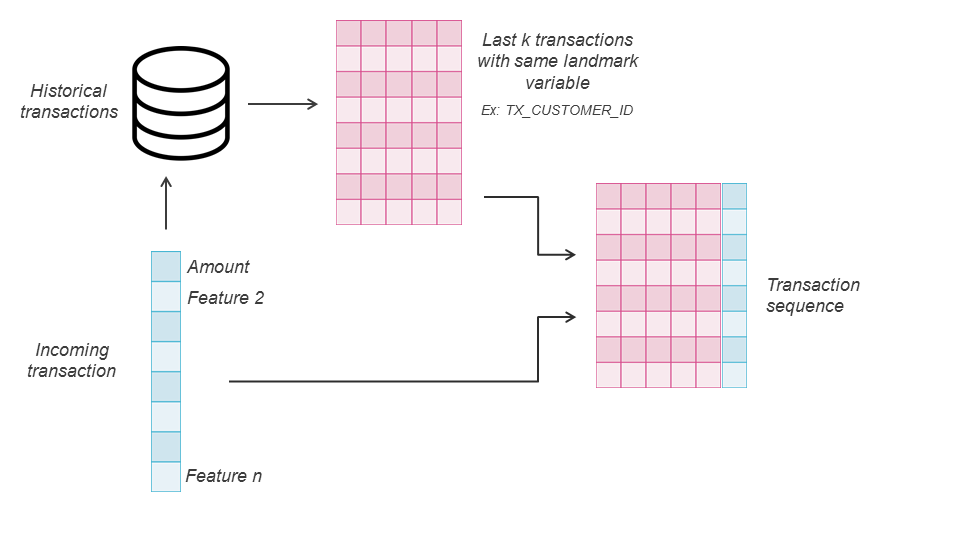



This whole sequence is the raw basis for context-aware approaches.

For example, the **automatic representations learning** framework considers the sequence directly as input in a model and lets it automatically learn the right connections to optimize fraud detection. However, this requires a sufficiently large dataset to properly identify the relevant patterns. Otherwise, the feature representations are not very accurate or useful. 

The required steps are:
* Turn the input sequences into fixed-size sequences
* Use a special family of models that are able to deal with sequences naturally and to summarize them into relevant vector representations for fraud classification. 





This strategy is often referred to as *sequential learning*, i.e. the study of learning algorithms for sequential data. The sequential dependency between data points is learned at the algorithmic level. This includes:
* **Sliding window methods**, which often tend to ignore the order between data points within the window (e.g. 1D convolutional neural networks).
* **Sequential models** that are designed explicitly to consider the sequential order between consecutive data points (e.g. recurrent neural networks like LSTM). The link between consecutive elements of the sequence can be embedded in the design of the recurrent architecture, where the computation of the hidden state/layer of a more recent event depends on hidden states of previous events. 

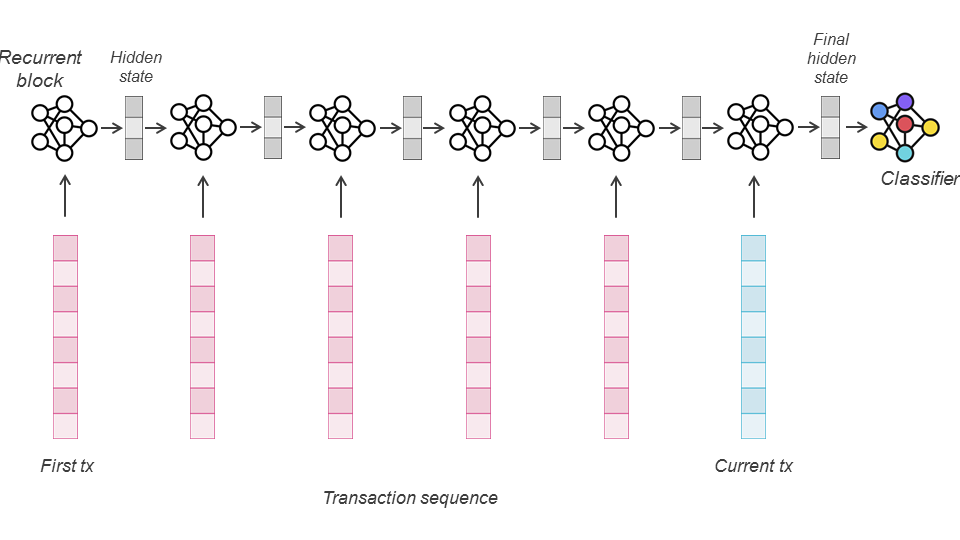

### Utils

**Dataset**

In [ ]:
class FraudSequenceDataset(torch.utils.data.Dataset):
    
    def __init__(self, x,y,customer_ids, dates, seq_len, padding_mode = 'zeros', output=True):
        'Initialization'
        
        # x,y,customer_ids, and dates must have the same length
        
        # storing the features x in self.features and adding the "padding" transaction at the end
        if padding_mode == "mean":
            self.features = torch.vstack([x, x.mean(axis=0)])
        elif padding_mode == "zeros":
            self.features = torch.vstack([x, torch.zeros(x[0,:].shape)])            
        else:
            raise ValueError('padding_mode must be "mean" or "zeros"')
        self.y = y
        self.customer_ids = customer_ids
        self.dates = dates
        self.seq_len = seq_len
        self.output = output
        
        #===== computing sequences ids =====  
        
        
        df_ids_dates = pd.DataFrame({'CUSTOMER_ID':customer_ids,
        'TX_DATETIME':dates})
        
        df_ids_dates["tmp_index"]  = np.arange(len(df_ids_dates))
        df_groupby_customer_id = df_ids_dates.groupby("CUSTOMER_ID")
        sequence_indices = pd.DataFrame(
            {
                "tx_{}".format(n): df_groupby_customer_id["tmp_index"].shift(seq_len - n - 1)
                for n in range(seq_len)
            }
        )
        
        #replaces -1 (padding) with the index of the padding transaction (last index of self.features)
        self.sequences_ids = sequence_indices.fillna(len(self.features) - 1).values.astype(int)              


    def __len__(self):
        'Denotes the total number of samples'
        # not len(self.features) because of the added padding transaction
        return len(self.customer_ids)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample index
        
        tx_ids = self.sequences_ids[index]
        
        if self.output:
            #transposing because the CNN considers the channel dimension before the sequence dimension
            return self.features[tx_ids,:].transpose(0,1).to(DEVICE), self.y[index].to(DEVICE)
        else:
            return self.features[tx_ids,:].transpose(0,1).to(DEVICE)

**CNN**

In [ ]:
class FraudConvNet(torch.nn.Module):
    
        def __init__(self, 
                     num_features, 
                     seq_len,hidden_size = 100, 
                     conv1_params = (100,2), 
                     conv2_params = None, 
                     max_pooling = True):
            
            super(FraudConvNet, self).__init__()
            
            # parameters
            self.num_features = num_features
            self.hidden_size = hidden_size
            
            # representation learning part
            self.conv1_num_filters  = conv1_params[0]
            self.conv1_filter_size  = conv1_params[1]
            self.padding1 = torch.nn.ConstantPad1d((self.conv1_filter_size - 1,0),0)
            self.conv1 = torch.nn.Conv1d(num_features, self.conv1_num_filters, self.conv1_filter_size)
            self.representation_size = self.conv1_num_filters
            
            self.conv2_params = conv2_params
            if conv2_params:
                self.conv2_num_filters  = conv2_params[0]
                self.conv2_filter_size  = conv2_params[1]
                self.padding2 = torch.nn.ConstantPad1d((self.conv2_filter_size - 1,0),0)
                self.conv2 = torch.nn.Conv1d(self.conv1_num_filters, self.conv2_num_filters, self.conv2_filter_size)
                self.representation_size = self.conv2_num_filters
            
            self.max_pooling = max_pooling
            if max_pooling:
                self.pooling = torch.nn.MaxPool1d(seq_len)
            else:
                self.representation_size = self.representation_size*seq_len
                
            # feed forward part at the end
            self.flatten = torch.nn.Flatten()
                        
            #representation to hidden
            self.fc1 = torch.nn.Linear(self.representation_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            
            #hidden to output
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
            
        def forward(self, x):
            
            representation = self.conv1(self.padding1(x))
            
            if self.conv2_params:
                representation = self.conv2(self.padding2(representation))
                        
            if self.max_pooling:
                representation = self.pooling(representation)
                        
            representation = self.flatten(representation)
            
            hidden = self.fc1(representation)
            relu = self.relu(hidden)
            
            output = self.fc2(relu)
            output = self.sigmoid(output)
            
            return output

**LSTM**

In [ ]:
class FraudLSTM(torch.nn.Module):
    
        def __init__(self, 
                     num_features,
                     hidden_size = 100, 
                     hidden_size_lstm = 100, 
                     num_layers_lstm = 1,
                     dropout_lstm = 0):
            
            super(FraudLSTM, self).__init__()
            # parameters
            self.num_features = num_features
            self.hidden_size = hidden_size
            
            # representation learning part
            self.lstm = torch.nn.LSTM(self.num_features, 
                                      hidden_size_lstm, 
                                      num_layers_lstm, 
                                      batch_first = True, 
                                      dropout = dropout_lstm)
                
                        
            #representation to hidden
            self.fc1 = torch.nn.Linear(hidden_size_lstm, self.hidden_size)
            self.relu = torch.nn.ReLU()
            
            #hidden to output
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
            
        def forward(self, x):
            
            #transposing sequence length and number of features before applying the LSTM 
            representation = self.lstm(x.transpose(1,2))

            #the second element of representation is a tuple with (final_hidden_states,final_cell_states)  
            #since the LSTM has 1 layer and is unidirectional, final_hidden_states has a single element
            hidden = self.fc1(representation[1][0][0])
            relu = self.relu(hidden)
            
            output = self.fc2(relu)
            output = self.sigmoid(output)
            
            return output

**Attention**

In [ ]:
# Attention module taken from
# https://github.com/IBM/pytorch-seq2seq/blob/master/seq2seq/models/attention.py 

import torch.nn.functional as F

class Attention(torch.nn.Module):
    r"""
    Applies an attention mechanism on the output features from the decoder.
    .. math::
            \begin{array}{ll}
            x = context*output \\
            attn = exp(x_i) / sum_j exp(x_j) \\
            output = \tanh(w * (attn * context) + b * output)
            \end{array}
    Args:
        dim(int): The number of expected features in the output
    Inputs: output, context
        - **output** (batch, output_len, dimensions): tensor containing the output features from the decoder.
        - **context** (batch, input_len, dimensions): tensor containing features of the encoded input sequence.
    Outputs: output, attn
        - **output** (batch, output_len, dimensions): tensor containing the attended output features from the decoder.
        - **attn** (batch, output_len, input_len): tensor containing attention weights.
    Attributes:
        linear_out (torch.nn.Linear): applies a linear transformation to the incoming data: :math:`y = Ax + b`.
        mask (torch.Tensor, optional): applies a :math:`-inf` to the indices specified in the `Tensor`.
    Examples::
         >>> attention = seq2seq.models.Attention(256)
         >>> context = Variable(torch.randn(5, 3, 256))
         >>> output = Variable(torch.randn(5, 5, 256))
         >>> output, attn = attention(output, context)
    """
    def __init__(self, dim):
        super(Attention, self).__init__()
        self.linear_out = torch.nn.Linear(dim*2, dim)
        self.mask = None

    def set_mask(self, mask):
        """
        Sets indices to be masked
        Args:
            mask (torch.Tensor): tensor containing indices to be masked
        """
        self.mask = mask

    def forward(self, output, context):
        batch_size = output.size(0)
        hidden_size = output.size(2)
        input_size = context.size(1)
        # (batch, out_len, dim) * (batch, in_len, dim) -> (batch, out_len, in_len)
        attn = torch.bmm(output, context.transpose(1, 2))
        if self.mask is not None:
            attn.data.masked_fill_(self.mask, -float('inf'))
        attn = F.softmax(attn.view(-1, input_size), dim=1).view(batch_size, -1, input_size)

        # (batch, out_len, in_len) * (batch, in_len, dim) -> (batch, out_len, dim)
        mix = torch.bmm(attn, context)

        # concat -> (batch, out_len, 2*dim)
        combined = torch.cat((mix, output), dim=2)
        # output -> (batch, out_len, dim)
        output = F.tanh(self.linear_out(combined.view(-1, 2 * hidden_size))).view(batch_size, -1, hidden_size)

        return output, attn

In [ ]:
class FraudLSTMWithAttention(torch.nn.Module):
    
        def __init__(self, 
                     num_features,
                     hidden_size = 100, 
                     hidden_size_lstm = 100, 
                     num_layers_lstm = 1,
                     dropout_lstm = 0, 
                     attention_out_dim = 100):
            
            super(FraudLSTMWithAttention, self).__init__()
            # parameters
            self.num_features = num_features
            self.hidden_size = hidden_size
            
            # sequence representation
            self.lstm = torch.nn.LSTM(self.num_features, 
                                      hidden_size_lstm, 
                                      num_layers_lstm, 
                                      batch_first = True, 
                                      dropout = dropout_lstm)
            
            # layer that will project the last transaction of the sequence into a context vector
            self.ff = torch.nn.Linear(self.num_features, hidden_size_lstm)
            
            # attention layer
            self.attention = Attention(attention_out_dim)
                        
            #representation to hidden
            self.fc1 = torch.nn.Linear(hidden_size_lstm, self.hidden_size)
            self.relu = torch.nn.ReLU()
            
            #hidden to output
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
            
        def forward(self, x):
            
            #computing the sequence of hidden states from the sequence of transactions
            hidden_states, _ = self.lstm(x.transpose(1,2))
            
            #computing the context vector from the last transaction
            context_vector = self.ff(x[:,:,-1:].transpose(1,2))
            
            combined_state, attn = self.attention(context_vector, hidden_states)

                        
            hidden = self.fc1(combined_state[:,0,:])
            relu = self.relu(hidden)
            
            output = self.fc2(relu)
            output = self.sigmoid(output)
            
            return output

**Training and testing**

In [ ]:
def get_all_predictions(model, generator):
    model.eval()
    all_preds = []
    for x_batch, y_batch in generator:
        # Forward pass
        y_pred = model(x_batch)
        # append to all preds
        all_preds.append(y_pred.detach().cpu().numpy())
    return np.vstack(all_preds)

### Context sequence setting

In [ ]:
# Setting the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = delta_valid = 7

start_date_training_with_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))

(train_df, valid_df) = get_train_test_set(transactions_df,start_date_training_with_valid,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

(train_df, valid_df) = scaleData(train_df, valid_df, input_features)

Building the context sequence requires two additional features from the input features: `CUSTOMER_ID` and `TX_DATETIME`.

In [ ]:
dates = train_df['TX_DATETIME'].values
customer_ids = train_df['CUSTOMER_ID'].values

In [ ]:
# Set the context sequence length
seq_len = 5

# Transactions are already sorted, but in the most general case
# we would neet to sort all transactions chronologically and keep the sorting indices
indices_sort = np.argsort(dates)
sorted_dates = dates[indices_sort]
sorted_ids = customer_ids[indices_sort]

# Separate data according to the landmark variable, i.e. the Customer ID
unique_customer_ids = np.unique(sorted_ids)

**Example for CUSTOMER_ID = 0**

For each customer, the associated transactions can be selected with a boolean mask. 

In [ ]:
idx = 0
current_customer_id = unique_customer_ids[idx]
customer_mask = sorted_ids == current_customer_id
# this is the full sequence of transaction indices for customer 0
customer_full_seq = np.where(customer_mask)[0]
customer_full_seq  # <-- the context sequence would be a subsequence of this array

array([ 1888, 10080, 12847, 15627, 18908, 22842, 37972, 42529, 44495,
       48980, 58692, 63977])

The above sequence is the whole sequence for customer `0`. But the goal is to have, for each transaction `i` of this sequence, a fixed size sequence that ends with transaction `i`, which will be used as input in the sequential model to predict the label of transaction `i`.

Using a sliding window allows to obtain those sequences (value $-1$ indicates no context).

In [ ]:
def rolling_window(array, window):
    a = np.concatenate([np.ones((window-1,))*-1,array])
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides).astype(int)

customer_all_seqs = rolling_window(customer_full_seq, seq_len)
customer_all_seqs

array([[   -1,    -1,    -1,    -1,  1888],
       [   -1,    -1,    -1,  1888, 10080],
       [   -1,    -1,  1888, 10080, 12847],
       [   -1,  1888, 10080, 12847, 15627],
       [ 1888, 10080, 12847, 15627, 18908],
       [10080, 12847, 15627, 18908, 22842],
       [12847, 15627, 18908, 22842, 37972],
       [15627, 18908, 22842, 37972, 42529],
       [18908, 22842, 37972, 42529, 44495],
       [22842, 37972, 42529, 44495, 48980],
       [37972, 42529, 44495, 48980, 58692],
       [42529, 44495, 48980, 58692, 63977]])

From the sequences of indeces, i.e. the rows of the previous matrix, building the features sequences is straightforward. Let's do an example for row $6$.

In [ ]:
x_train = torch.FloatTensor(train_df[input_features].values)
context_sequence_6 = x_train[customer_all_seqs[5], :]
print(context_sequence_6)
print(context_sequence_6.shape)

tensor([[ 0.6965, -0.6306,  2.1808, -0.8466,  0.0336, -1.1665,  0.0176, -0.9341,
          0.2310, -0.9810, -0.0816, -0.3445, -0.1231, -0.2491, -0.1436],
        [ 0.0358, -0.6306, -0.4586, -0.8466,  0.4450, -1.1665,  0.1112, -0.8994,
          0.2278,  0.0028, -0.0816,  0.6425, -0.1231, -0.0082, -0.1436],
        [ 1.1437, -0.6306, -0.4586, -0.3003,  0.7595, -1.0352,  0.2462, -0.8994,
          0.2458,  1.9702, -0.0816,  1.3005, -0.1231,  1.7989, -0.1436],
        [ 0.3645, -0.6306, -0.4586,  0.2461,  0.6804, -1.0352,  0.3186, -0.8647,
          0.2514,  1.9702, -0.0816,  0.3135, -0.1231, -0.8514, -0.1436],
        [ 0.3348, -0.6306, -0.4586, -0.3003,  0.7462, -1.1665,  0.2494, -0.8994,
          0.2262, -0.9810, -0.0816, -2.3185, -0.1231, -1.5743, -0.1436]])
torch.Size([5, 15])


Here, the sequence of indices was made of valid indices. When there are invalid indices (`-1`), the idea is to put a "padding transaction" (e.g. with all features equal to zero or equal to the average value that they have in the training set) in the final sequence. To obtain a homogeneous code that can be used for both valid and invalid indices, one can append the "padding transaction" to `x_train` at the end and replace all `-1` with the index of this added transaction.

**Implementation for all costumers**

In [ ]:
df_ids_dates = pd.DataFrame({'CUSTOMER_ID': customer_ids, 'TX_DATETIME': dates})

# Check if the transaction are chronologically ordered
datetime_diff = (df_ids_dates["TX_DATETIME"] - df_ids_dates["TX_DATETIME"].shift(1)).iloc[1:].dt.total_seconds()
assert (datetime_diff >= 0).all()

# Add a column of temporary indeces from '0' to 'len(df_ids_dates)' 
# which is useful to be used with the shift function
df_ids_dates["tmp_index"]  = np.arange(len(df_ids_dates))

# Group by CUSTOMER_ID
df_groupby_customer_id = df_ids_dates.groupby("CUSTOMER_ID")

Now it is possible to compute a shifted `tmp_index` with respect to the grouping by `CUSTOMER_ID`. For instance, shifting by $0$ gives the current transaction index and shifting by $1$ gives the previous transaction index (or NaN if the current transaction is the first transaction of the customer).

In [ ]:
df_groupby_customer_id["tmp_index"].shift(0)

0            0
1            1
2            2
3            3
4            4
         ...  
66923    66923
66924    66924
66925    66925
66926    66926
66927    66927
Name: tmp_index, Length: 66928, dtype: int64

In [ ]:
df_groupby_customer_id["tmp_index"].shift(1)

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
66923    66805.0
66924    64441.0
66925    66777.0
66926    63338.0
66927    60393.0
Name: tmp_index, Length: 66928, dtype: float64

To obtain the whole sequences of indices, we must loop over the shift parameter, from (seq_len$-1$) to $0$. 

In [ ]:
sequence_indices = pd.DataFrame(
            {"tx_{}".format(n): df_groupby_customer_id["tmp_index"].shift(seq_len - n - 1)
             for n in range(seq_len)}
)

sequence_indices = sequence_indices.fillna(-1).astype(int)

Create the torch dataset

In [ ]:
if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

Selected device is cuda


In [ ]:
# Allow reproducibility
SEED = 42

In [ ]:
x_train = torch.FloatTensor(train_df[input_features].values)
x_valid = torch.FloatTensor(valid_df[input_features].values)
y_train = torch.FloatTensor(train_df[output_feature].values)
y_valid = torch.FloatTensor(valid_df[output_feature].values)

# Generators
seed_everything(SEED)
train_loader_params = {'batch_size': 64, 'shuffle': True, 'num_workers': 0}
training_set = FraudSequenceDataset(x_train, y_train,train_df['CUSTOMER_ID'].values, train_df['TX_DATETIME'].values,seq_len,padding_mode = "zeros")
training_generator = torch.utils.data.DataLoader(training_set, **train_loader_params)

x_batch, y_batch = next(iter(training_generator))
print('x_batch shape: ', x_batch.shape)
print('y_batch shape: ', y_batch.shape)

x_batch shape:  torch.Size([64, 15, 5])
y_batch shape:  torch.Size([64])


### 1D Convolutional Neural Network

If the input is a 3D image, then the user only defines 2 dimensions for the filter (along the "sliding" directions) but the filters are in reality 3D as well, the last dimension matching the RGB channel dimension.

2D-convolutions are only used to analyze inputs for which it makes sense to slide along 2 dimensions. In our case, to deal with transaction sequences, it only makes sense to slide along the sequence axis. Therefore, for fraud detection, we resort to 1D-convolutions and define a single filter dimension (with length equal to the number of consecutive sequence elements on which the filter looks for patterns).

In [ ]:
seed_everything(SEED)

training_set = FraudSequenceDataset(x_train, 
                                    y_train, 
                                    train_df['CUSTOMER_ID'].values, 
                                    train_df['TX_DATETIME'].values,
                                    seq_len,
                                    padding_mode = "zeros")

valid_set = FraudSequenceDataset(x_valid, 
                                 y_valid,
                                 valid_df['CUSTOMER_ID'].values, 
                                 valid_df['TX_DATETIME'].values,
                                 seq_len,
                                 padding_mode = "zeros")

training_generator, valid_generator = prepare_generators(training_set, valid_set, batch_size=64)

cnn = FraudConvNet(x_train.shape[1], seq_len).to(DEVICE)
cnn

FraudConvNet(
  (padding1): ConstantPad1d(padding=(1, 0), value=0)
  (conv1): Conv1d(15, 100, kernel_size=(2,), stride=(1,))
  (pooling): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
optimizer = torch.optim.Adam(cnn.parameters(), lr = 0.0001)
criterion = torch.nn.BCELoss().to(DEVICE)
cnn,training_execution_time,train_losses_cnn,valid_losses_cnn = \
    training_loop(cnn,
                  training_generator,
                  valid_generator,
                  optimizer,
                  criterion,
                  verbose=True)


Epoch 0: train loss: 0.11350999406074133
valid loss: 0.043327614497596936
New best score: 0.043327614497596936

Epoch 1: train loss: 0.04622721349300521
valid loss: 0.030075086561372616
New best score: 0.030075086561372616

Epoch 2: train loss: 0.03614303975407903
valid loss: 0.026291770793629883
New best score: 0.026291770793629883

Epoch 3: train loss: 0.03290863055713567
valid loss: 0.02490975226178928
New best score: 0.02490975226178928

Epoch 4: train loss: 0.030797769878474535
valid loss: 0.02411676398020421
New best score: 0.02411676398020421

Epoch 5: train loss: 0.02929565237757588
valid loss: 0.023185229011623017
New best score: 0.023185229011623017

Epoch 6: train loss: 0.027989091769655024
valid loss: 0.022387664960799077
New best score: 0.022387664960799077

Epoch 7: train loss: 0.02698870491722588
valid loss: 0.022145575248061225
New best score: 0.022145575248061225

Epoch 8: train loss: 0.02626157726270697
valid loss: 0.02172451234903553
New best score: 0.02172451234903

In [ ]:
valid_predictions = get_all_predictions(cnn, valid_generator)
predictions_df = valid_df
predictions_df['predictions'] = valid_predictions[:, 0]
cnn_performance = performance_assessment(predictions_df, top_k_list=[100])
cnn_performance

AUC ROC  Average precision  Card Precision@100
0     0.85              0.566               0.264

### Long Short-Term Memory Network (LSTM)

The computations in an RNN are very similar to a regular feed-forward network, except that:
* there are multiple input vectors in the form of sequence instead of a single input vector
* the order of the vectors is taken into account.

Indeed, a RNN performs a succession of computations that follow the order of inputs in the sequence. In particular, it repeats a recurrent unit (a network with regular layers), from the first item to the last, that each time takes as input the output of hidden neurons (hidden state) from the previous step and the current item of the input sequence to produce a new output and a new hidden state. 

The specificity of the LSTM is its advanced combination of the hidden state and the current sequence item to produce the new hidden state. In particular, it makes use of several gates (neurons with sigmoid activations) to💡cleverly select the right information to keep from the previous state and the right information to integrate from the current input💡.

When the LSTM takes as input a sequence of `seq_len` transactions, it produces a sequence of `seq_len` hidden states of dimension `hidden_dim`. The final hidden state is an aggregated representation of the whole sequence, as long as the sequence is not too long, which can be used as input in a feed-forward layer to classify the last transaction as either fraudulent or genuine. 

In [ ]:
seed_everything(SEED)

training_generator, valid_generator = prepare_generators(training_set, valid_set,batch_size=64)

lstm = FraudLSTM(x_train.shape[1]).to(DEVICE)
optimizer = torch.optim.Adam(lstm.parameters(), lr = 0.0001)
criterion = torch.nn.BCELoss()

lstm, training_execution_time, train_losses_lstm, valid_losses_lstm = \
    training_loop(lstm,
                  training_generator,
                  valid_generator,
                  optimizer,
                  criterion,
                  verbose=True)


Epoch 0: train loss: 0.13896286704717292
valid loss: 0.02635791426132652
New best score: 0.02635791426132652

Epoch 1: train loss: 0.031485119006502124
valid loss: 0.0228844301609699
New best score: 0.0228844301609699

Epoch 2: train loss: 0.02760154585911399
valid loss: 0.021432163001450358
New best score: 0.021432163001450358

Epoch 3: train loss: 0.02537582052584887
valid loss: 0.020624358941358133
New best score: 0.020624358941358133

Epoch 4: train loss: 0.024116150487702246
valid loss: 0.020167552142867137
New best score: 0.020167552142867137

Epoch 5: train loss: 0.023354181265244776
valid loss: 0.0196436917329146
New best score: 0.0196436917329146

Epoch 6: train loss: 0.022872800589650407
valid loss: 0.019940685887205226
1  iterations since best score.

Epoch 7: train loss: 0.0224378073609605
valid loss: 0.020230126903326213
2  iterations since best score.

Epoch 8: train loss: 0.022016305163240924
valid loss: 0.01912326198554715
New best score: 0.01912326198554715

Epoch 9: 

In [ ]:
valid_predictions = get_all_predictions(lstm, valid_generator)
predictions_df = valid_df
predictions_df['predictions'] = valid_predictions[:, 0]
lstm_performance = performance_assessment(predictions_df, top_k_list=[100])
lstm_performance

AUC ROC  Average precision  Card Precision@100
0    0.859              0.653               0.276

### Attention-based models

The Attention mechanism allows to:
* align the usage of the encoder's hidden states and the element currently being generated by the decoder
* solve the long-range dependency problem of LSTMs.

The difference with the regular usage of an LSTM is that instead of only using the last hidden state, the Attention mechanism takes as input all the hidden states and combines them in a relevant manner with respect to a certain context. More precisely it performs the following operations:
* Given a context vector $c$ and the sequence of hidden states $h_i$, it computes an attention score $a_i$ for each hidden state, generally using a similarity measure like a dot product between $c$ and $h_i$.
* It normalizes all the attention scores with a softmax.
* It computes a global output state with a linear combination $\sum a_i*h_i$.

For applications like machine translation with an encoder-decoder architecture, the context vector will generally be the current hidden state of the decoder, and the Attention will be applied to all hidden states of the encoder. In such application, the encoder LSTM takes as input a sentence in a language, and the decoder LSTM takes as input the beginning of the translated sentence in another language. Therefore, it makes sense to consider the current state of the translation as context to select the elements of the input sequence that will be taken into account to predict the next word of the translation. 




For fraud detection, only an encoder LSTM is used in our implementation above. The choice of a relevant context vector will therefore be based on our intuition of what kind of context makes sense to select the correct hidden states of the sequence. A reasonable choice is to consider a representation of the transaction that we aim at classifying (the last transaction) as context to select the correct elements from the previous transactions. As representation, we'll use a projection of the last transaction (e.g. applying a `torch.nn.Linear` layer). 

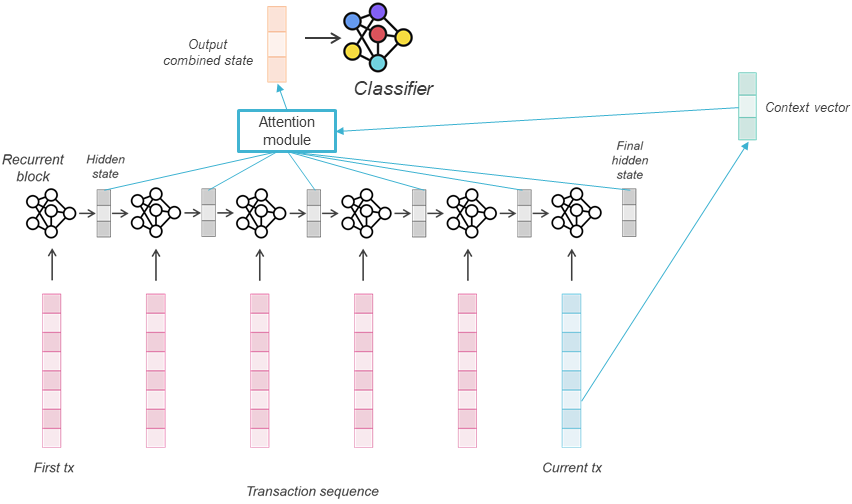

We are going to use a custom `Attention` module from https://github.com/IBM/pytorch-seq2seq/blob/master/seq2seq/models/attention.py.

During the forward pass, it takes as input the sequence of hidden states and the context vector and outputs the combined state and the attention scores. 

**Toy example**

In [ ]:
# Select a random training batch
x_batch, y_batch = next(iter(training_generator))

# Compute the hidden states of LSTM
output_lstm, (last_hidden, last_cell) = lstm.lstm(x_batch.transpose(1,2))
  # --> output_lstm is the sequence of all hidden states
  # --> last_hidden is the last hidden state
  # --> last_cell is the last cell state

# Create the context vector from the last element of the input, i.e. x_batch[:,:,-1:]
context_projector = torch.nn.Linear(x_batch.shape[1], output_lstm.shape[2]).to(DEVICE)
context_vector = context_projector(x_batch[:,:,-1:].transpose(1,2))

print('Shape of the sequence of all hidden states: ', output_lstm.shape)
print('Shape of the context sequence : ', context_vector.shape)

Shape of the sequence of all hidden states:  torch.Size([64, 5, 100])
Shape of the context sequence :  torch.Size([64, 1, 100])


In [ ]:
test_attention = Attention(100).to(DEVICE)
output_attn, score_attn = test_attention(context_vector, output_lstm)
  # --> output_attn is the output combined state, i.e. the linear combination 
  #     of the hidden states based on the attention scores
  # --> score_attn is the attention score of the hidden states
print('Shape of the Attention output combined state: ', output_attn.shape)
print('Attention scores of the 5 hidden layers: ')
score_attn[0, 0]

Shape of the Attention output combined state:  torch.Size([64, 1, 100])
Attention scores of the 5 hidden layers: 


tensor([0.3775, 0.3201, 0.1642, 0.0902, 0.0481], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [ ]:
# If we use the last hidden state of LSTM, i.e. output_lstm[:,4:,:], as context vector
output_attn, score_attn = test_attention(output_lstm[:,4:,:], output_lstm)
# Then the attention score is much larger for the last transaction, 
# since it is equal to the context vector
score_attn[0, 0]

tensor([1.2113e-07, 9.5342e-07, 4.9331e-05, 7.0942e-03, 9.9286e-01],
       device='cuda:0', grad_fn=<SelectBackward0>)

**Complete implementation**

In [ ]:
seed_everything(SEED)

lstm_attn = FraudLSTMWithAttention(x_train.shape[1]).to(DEVICE)
lstm_attn

FraudLSTMWithAttention(
  (lstm): LSTM(15, 100, batch_first=True)
  (ff): Linear(in_features=15, out_features=100, bias=True)
  (attention): Attention(
    (linear_out): Linear(in_features=200, out_features=100, bias=True)
  )
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
training_generator, valid_generator = prepare_generators(training_set, valid_set, batch_size=64)

optimizer = torch.optim.Adam(lstm_attn.parameters(), lr = 0.00008)
criterion = torch.nn.BCELoss().to(DEVICE)

lstm_attn, training_execution_time, train_losses_lstm_attn, valid_losses_lstm_attn = \
    training_loop(lstm_attn,
                  training_generator,
                  valid_generator,
                  optimizer,
                  criterion,
                  verbose=True)


Epoch 0: train loss: 0.10345629579565678
valid loss: 0.02170216915416506
New best score: 0.02170216915416506

Epoch 1: train loss: 0.026198114388681106
valid loss: 0.020528788957235918
New best score: 0.020528788957235918

Epoch 2: train loss: 0.02440664835394864
valid loss: 0.01964796965043544
New best score: 0.01964796965043544

Epoch 3: train loss: 0.023379737649395185
valid loss: 0.019510676405428213
New best score: 0.019510676405428213

Epoch 4: train loss: 0.02279390925835341
valid loss: 0.019047171292989388
New best score: 0.019047171292989388

Epoch 5: train loss: 0.022291946418856734
valid loss: 0.018896261558109702
New best score: 0.018896261558109702

Epoch 6: train loss: 0.021782337433265
valid loss: 0.01876629324199866
New best score: 0.01876629324199866

Epoch 7: train loss: 0.021481879020998358
valid loss: 0.018841431261284552
1  iterations since best score.

Epoch 8: train loss: 0.020978714296141066
valid loss: 0.018686202711863394
New best score: 0.018686202711863394


In [ ]:
valid_predictions = get_all_predictions(lstm_attn, valid_generator)
predictions_df = valid_df
predictions_df['predictions'] = valid_predictions[:,0]
lstm_attn_performance = performance_assessment(predictions_df, top_k_list=[100])
lstm_attn_performance

AUC ROC  Average precision  Card Precision@100
0    0.862              0.659               0.273

### Model comparison

In [ ]:
summary = pd.concat([cnn_performance, lstm_performance, lstm_attn_performance], axis=0)
summary.index = ['1D CNN', 'LSTM', 'LSTM + Attention']
summary

AUC ROC  Average precision  Card Precision@100
1D CNN              0.850              0.566               0.264
LSTM                0.859              0.653               0.276
LSTM + Attention    0.862              0.659               0.273

Of course the hyperparameters can be finetuned to obtain optimal scores.

# **6. Final comparison**

In [ ]:
summary = pd.concat([knn_performance, logistic_reg_performance, decision_tree_performance,
                     random_forest_performance, xgboost_performance, xgboost_balanced_3_performance,
                     xgboost_smote_performance, xgboost_rand_performance,
                     xgboost_enn_performance, xgboost_hybrid_performance,
                     bagging_performance, balanced_rf_performance,
                     model_wo_emb_performance, model_emb_performance,
                     ae_performance, if_performance, supervised_ae_performance,
                     cnn_performance, lstm_performance, lstm_attn_performance], axis=0)
summary.index = ['KNN', 'Logistic Regression', 'Decision Tree', 
                 'Random Forest', 'XGBoost', 'Balanced XGBoost',
                 'SMOTE oversampling + XGBoost', 'Random undersampling + XGBoost', 
                 'ENN undersampling + XGBoost', 'Hybrid resampling + XGBoost',
                 'Balanced Bagging', 'Balanced Random Forest',
                 'Feed-forward NN', 'Feed-forward NN + Embeddings',
                 'Autoencorder', 'Isolation Forest', 'Semi-supervised NN + AE',
                 '1D CNN', 'LSTM', 'LSTM + Attention']

In [ ]:
summary.sort_values(by='AUC ROC', ascending=False)

AUC ROC  Average precision  Card Precision@100
Balanced XGBoost                  0.887              0.680               0.280
Balanced Bagging                  0.885              0.639               0.280
Random undersampling + XGBoost    0.878              0.679               0.283
XGBoost                           0.877              0.683               0.283
Feed-forward NN                   0.874              0.677               0.283
SMOTE oversampling + XGBoost      0.874              0.675               0.283
Hybrid resampling + XGBoost       0.874              0.675               0.283
ENN undersampling + XGBoost       0.870              0.648               0.281
Balanced Random Forest            0.868              0.669               0.279
Random Forest                     0.867              0.634               0.273
LSTM + Attention                  0.862              0.659               0.273
LSTM                              0.859              0.653               0.276
Logistic Regression               0.858              0.596               0.267
Semi-supervised NN + AE           0.857              0.624               0.276
1D CNN                            0.850              0.566               0.264
Feed-forward NN + Embeddings      0.842              0.585               0.266
Autoencorder                      0.840              0.163               0.200
Decision Tree                     0.820              0.324               0.259
Isolation Forest                  0.808              0.164               0.190
KNN                               0.803              0.511               0.244

In [ ]:
summary.sort_values(by='Average precision', ascending=False)

AUC ROC  Average precision  Card Precision@100
XGBoost                           0.877              0.683               0.283
Balanced XGBoost                  0.887              0.680               0.280
Random undersampling + XGBoost    0.878              0.679               0.283
Feed-forward NN                   0.874              0.677               0.283
SMOTE oversampling + XGBoost      0.874              0.675               0.283
Hybrid resampling + XGBoost       0.874              0.675               0.283
Balanced Random Forest            0.868              0.669               0.279
LSTM + Attention                  0.862              0.659               0.273
LSTM                              0.859              0.653               0.276
ENN undersampling + XGBoost       0.870              0.648               0.281
Balanced Bagging                  0.885              0.639               0.280
Random Forest                     0.867              0.634               0.273
Semi-supervised NN + AE           0.857              0.624               0.276
Logistic Regression               0.858              0.596               0.267
Feed-forward NN + Embeddings      0.842              0.585               0.266
1D CNN                            0.850              0.566               0.264
KNN                               0.803              0.511               0.244
Decision Tree                     0.820              0.324               0.259
Isolation Forest                  0.808              0.164               0.190
Autoencorder                      0.840              0.163               0.200

In [ ]:
summary.sort_values(by='Card Precision@100', ascending=False)

AUC ROC  Average precision  Card Precision@100
XGBoost                           0.877              0.683               0.283
SMOTE oversampling + XGBoost      0.874              0.675               0.283
Random undersampling + XGBoost    0.878              0.679               0.283
Hybrid resampling + XGBoost       0.874              0.675               0.283
Feed-forward NN                   0.874              0.677               0.283
ENN undersampling + XGBoost       0.870              0.648               0.281
Balanced Bagging                  0.885              0.639               0.280
Balanced XGBoost                  0.887              0.680               0.280
Balanced Random Forest            0.868              0.669               0.279
LSTM                              0.859              0.653               0.276
Semi-supervised NN + AE           0.857              0.624               0.276
LSTM + Attention                  0.862              0.659               0.273
Random Forest                     0.867              0.634               0.273
Logistic Regression               0.858              0.596               0.267
Feed-forward NN + Embeddings      0.842              0.585               0.266
1D CNN                            0.850              0.566               0.264
Decision Tree                     0.820              0.324               0.259
KNN                               0.803              0.511               0.244
Autoencorder                      0.840              0.163               0.200
Isolation Forest                  0.808              0.164               0.190